In [ ]:
pip install transformers


In [ ]:
pip install tensorflow

In [ ]:
pip install -U imbalanced-learn

In [ ]:
pip install --upgrade keras


  Using cached keras-2.14.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.0 requires keras<2.14,>=2.13.1, but you have keras 2.14.0 which is incompatible.


In [ ]:
pip install --upgrade tensorflow


  Using cached keras-2.13.1-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0


In [ ]:
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import ADASYN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.layers import Attention, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
import seaborn as sns  # Add this import

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Load CSV dataset
data = pd.read_csv('/content/drive/MyDrive/Datasets/Equalised_eclipse_jdt_250each.csv')

# Count the number of samples for each class
class_counts = data['Priority'].value_counts()

# Find the class with the minimum number of samples
minority_class = class_counts.idxmin()

print("Minority class:", minority_class)
print(class_counts)


# Text preprocessing steps
def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase conversion
        text = text.lower()

        # Remove punctuation and special characters
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]
        text = ' '.join(tokens)

        # Stemming
        stemmer = PorterStemmer()
        tokens = text.split()
        tokens = [stemmer.stem(word) for word in tokens]
        text = ' '.join(tokens)

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        text = ' '.join(tokens)

    return text

# Apply text preprocessing to 'description' and 'title' columns
data['Description'] = data['Description'].apply(preprocess_text)
data['Title'] = data['Title'].apply(preprocess_text)

# Tokenize using DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_sequence_length = 3000

def tokenize_text(text):
    if isinstance(text, (str, int, float)):
        text = str(text)  # Convert text to string if it's not already

        tokens = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_sequence_length, padding='max_length', truncation=True)
        input_ids = tokens['input_ids']
        attention_mask = tokens['attention_mask']
    else:
        input_ids = []
        attention_mask = []
    return input_ids, attention_mask

# Apply tokenization to 'Description' and 'Title' columns
data['Description'] = data['Description'].apply(tokenize_text)
data['Title'] = data['Title'].apply(tokenize_text)

# Convert tokenized data to numpy arrays
input_ids = np.array([item[0] for item in data['Description']])
attention_masks = np.array([item[1] for item in data['Description']])

# Reshape input IDs and attention masks to have at most 2 dimensions
input_ids = input_ids.reshape(input_ids.shape[0], -1)
attention_masks = attention_masks.reshape(attention_masks.shape[0], -1)

# Concatenate input IDs and attention masks
X_input = np.concatenate((input_ids, attention_masks), axis=1)
y_input = data['Priority']

# # Apply ADASYN oversampling
# adasyn = ADASYN()
# X_resampled, y_resampled = adasyn.fit_resample(X_input, y_input)

# # Apply ADASYN oversampling
# if len(class_counts) > 1 and class_counts.iloc[-1] < class_counts.iloc[0]:
#     adasyn = ADASYN(n_neighbors=5, sampling_strategy='minority')
#     X_resampled, y_resampled = adasyn.fit_resample(X_input, y_input)
# else:
#     X_resampled, y_resampled = X_input, y_input

X_resampled, y_resampled = X_input, y_input

# Separate the resampled input IDs and attention masks
input_ids_resampled = X_resampled[:, :max_sequence_length]
attention_masks_resampled = X_resampled[:, max_sequence_length:]

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(input_ids_resampled, y_resampled, test_size=0.2, random_state=42)

# Pad sequences
X_train = pad_sequences(X_train, maxlen=max_sequence_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_sequence_length, padding='post', truncating='post')

from sklearn.preprocessing import LabelEncoder

# Encode string labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to categorical
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train_encoded, num_classes)
y_test = to_categorical(y_test_encoded, num_classes)

# Build HAN model
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(len(tokenizer.get_vocab()) + 1, 128)(input_layer)
word_encoder = Bidirectional(GRU(64, return_sequences=True))(embedding_layer)
word_attention = Attention()([word_encoder, word_encoder])
word_flatten = Flatten()(word_attention)
word_dense = Dense(64)(word_flatten)
word_repeat = RepeatVector(max_sequence_length)(word_dense)
sentence_encoder = Bidirectional(GRU(64, return_sequences=True))(word_repeat)
sentence_attention = Attention()([sentence_encoder, sentence_encoder])
sentence_flatten = Flatten()(sentence_attention)
sentence_dense = Dense(64)(sentence_flatten)
output_layer = Dense(num_classes, activation='softmax')(sentence_dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train the model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=10, callbacks=[early_stopping])

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Calculate precision, recall, and F1-score for each class
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_original = label_encoder.inverse_transform(y_test_encoded)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

precision = precision_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_)
recall = recall_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_)
f1 = f1_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_)

# Display precision, recall, and F1-score for each class
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1[i]:.4f}")
    print("="*30)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=label_encoder.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print model summary
model.summary()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Minority class: P1
P4    263
P3    256
P2    252
P5    252
P1    251
Name: Priority, dtype: int64
Epoch 1/10


ResourceExhaustedError: ignored

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/drive
Minority class: P1
P4    263
P3    256
P2    252
P5    252
P1    251
Name: Priority, dtype: int64


Epoch 1/10
32/32 [==============================] - 47s 1s/step - loss: 362.3629 - accuracy: 0.1963 - val_loss: 473.0077 - val_accuracy: 0.1882
Epoch 2/10
32/32 [==============================] - 30s 951ms/step - loss: 313.9104 - accuracy: 0.1776 - val_loss: 128.3058 - val_accuracy: 0.1882
Epoch 3/10
32/32 [==============================] - 30s 927ms/step - loss: 346.2737 - accuracy: 0.1933 - val_loss: 219.2477 - val_accuracy: 0.2039
Epoch 4/10
32/32 [==============================] - 29s 920ms/step - loss: 202.9143 - accuracy: 0.1825 - val_loss: 117.7130 - val_accuracy: 0.2118
Epoch 5/10
32/32 [==============================] - 36s 1s/step - loss: 204.5177 - accuracy: 0.2237 - val_loss: 252.9804 - val_accuracy: 0.2039
Epoch 6/10
32/32 [==============================] - 29s 889ms/step - loss: 294.1063 - accuracy: 0.2237 - val_loss: 302.6912 - val_accuracy: 0.1882
Epoch 7/10
32/32 [==============================] - 29s 903ms/step - loss: 196.1610 - accuracy: 0.2061 - val_loss: 77.1442 -

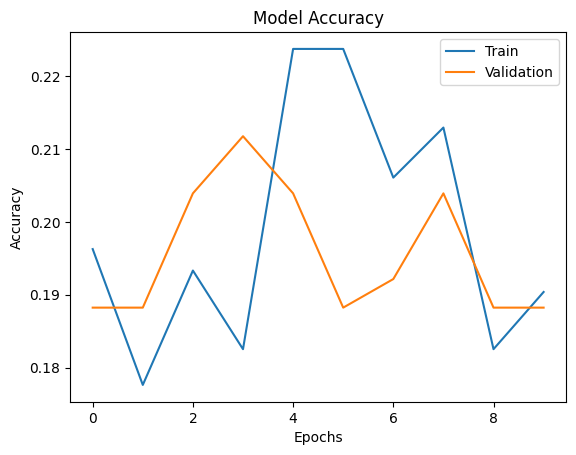

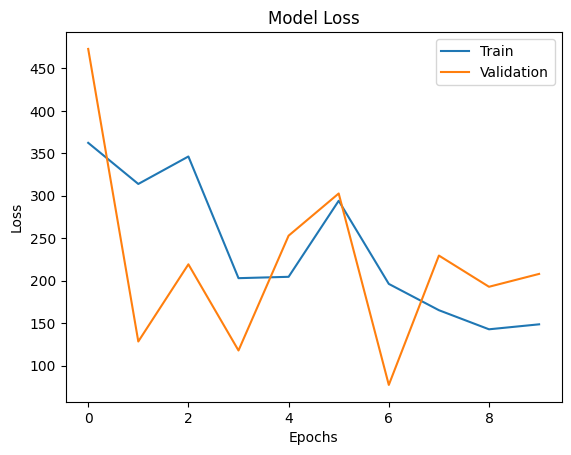

8/8 [==============================] - 3s 235ms/step
Class: P1
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Class: P2
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Class: P3
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Class: P4
Precision: 0.1922
Recall: 1.0000
F1-score: 0.3224
Class: P5
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


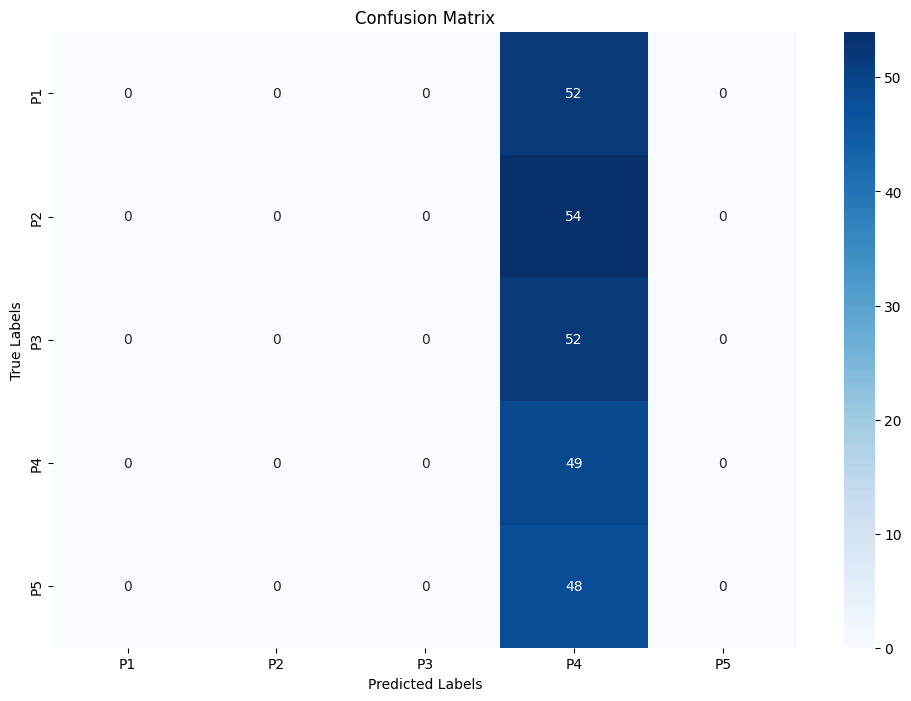

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3000)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 3000, 128)            3906944   ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 3000, 128)            74496     ['embedding[0][0]']           
 al)                                                                                              
                                                                                                  
 attention (Attention)       (None, 3000, 128)            0         ['bidirectional[0][0]',   

In [ ]:
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import ADASYN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.layers import Attention, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
import seaborn as sns  # Add this import

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Load CSV dataset
data = pd.read_csv('/content/drive/MyDrive/Datasets/Equalised_eclipse_jdt_250each.csv')

# Count the number of samples for each class
class_counts = data['Priority'].value_counts()

# Find the class with the minimum number of samples
minority_class = class_counts.idxmin()

print("Minority class:", minority_class)
print(class_counts)


# Text preprocessing steps
def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase conversion
        text = text.lower()

        # Remove punctuation and special characters
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]
        text = ' '.join(tokens)

        # Stemming
        stemmer = PorterStemmer()
        tokens = text.split()
        tokens = [stemmer.stem(word) for word in tokens]
        text = ' '.join(tokens)

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        text = ' '.join(tokens)

    return text

# Apply text preprocessing to 'description' and 'title' columns
data['Description'] = data['Description'].apply(preprocess_text)
data['Title'] = data['Title'].apply(preprocess_text)

# Tokenize using DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_sequence_length = 3000

def tokenize_text(text):
    if isinstance(text, (str, int, float)):
        text = str(text)  # Convert text to string if it's not already

        tokens = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_sequence_length, padding='max_length', truncation=True)
        input_ids = tokens['input_ids']
        attention_mask = tokens['attention_mask']
    else:
        input_ids = []
        attention_mask = []
    return input_ids, attention_mask

# Apply tokenization to 'Description' and 'Title' columns
data['Description'] = data['Description'].apply(tokenize_text)
data['Title'] = data['Title'].apply(tokenize_text)

# Convert tokenized data to numpy arrays
input_ids = np.array([item[0] for item in data['Description']])
attention_masks = np.array([item[1] for item in data['Description']])

# Reshape input IDs and attention masks to have at most 2 dimensions
input_ids = input_ids.reshape(input_ids.shape[0], -1)
attention_masks = attention_masks.reshape(attention_masks.shape[0], -1)

# Concatenate input IDs and attention masks
X_input = np.concatenate((input_ids, attention_masks), axis=1)
y_input = data['Priority']

# # Apply ADASYN oversampling
# adasyn = ADASYN()
# X_resampled, y_resampled = adasyn.fit_resample(X_input, y_input)

# # Apply ADASYN oversampling
# if len(class_counts) > 1 and class_counts.iloc[-1] < class_counts.iloc[0]:
#     adasyn = ADASYN(n_neighbors=5, sampling_strategy='minority')
#     X_resampled, y_resampled = adasyn.fit_resample(X_input, y_input)
# else:
#     X_resampled, y_resampled = X_input, y_input

X_resampled, y_resampled = X_input, y_input

# Separate the resampled input IDs and attention masks
input_ids_resampled = X_resampled[:, :max_sequence_length]
attention_masks_resampled = X_resampled[:, max_sequence_length:]

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(input_ids_resampled, y_resampled, test_size=0.2, random_state=42)

# Pad sequences
X_train = pad_sequences(X_train, maxlen=max_sequence_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_sequence_length, padding='post', truncating='post')

from sklearn.preprocessing import LabelEncoder

# Encode string labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to categorical
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train_encoded, num_classes)
y_test = to_categorical(y_test_encoded, num_classes)

# Build HAN model
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(len(tokenizer.get_vocab()) + 1, 128)(input_layer)
word_encoder = Bidirectional(GRU(64, return_sequences=True))(embedding_layer)
word_attention = Attention()([word_encoder, word_encoder])
word_flatten = Flatten()(word_attention)
word_dense = Dense(64)(word_flatten)
word_repeat = RepeatVector(max_sequence_length)(word_dense)
sentence_encoder = Bidirectional(GRU(64, return_sequences=True))(word_repeat)
sentence_attention = Attention()([sentence_encoder, sentence_encoder])
sentence_flatten = Flatten()(sentence_attention)
sentence_dense = Dense(64)(sentence_flatten)
output_layer = Dense(num_classes, activation='softmax')(sentence_dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10, callbacks=[early_stopping])

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Calculate precision, recall, and F1-score for each class
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_original = label_encoder.inverse_transform(y_test_encoded)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

# Calculate precision, recall, and F1-score with zero_division parameter
precision = precision_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_, zero_division=0)
recall = recall_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_, zero_division=0)
f1 = f1_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_, zero_division=0)

# Display precision, recall, and F1-score for each class
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1[i]:.4f}")
    print("="*30)


# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=label_encoder.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print model summary
model.summary()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Minority class: P1
P4    263
P3    256
P2    252
P5    252
P1    251
Name: Priority, dtype: int64
Epoch 1/10
32/32 [==============================] - 44s 1s/step - loss: 324.1908 - accuracy: 0.1776 - val_loss: 278.3524 - val_accuracy: 0.2039
Epoch 2/10
32/32 [==============================] - 29s 902ms/step - loss: 324.1322 - accuracy: 0.1963 - val_loss: 211.4690 - val_accuracy: 0.1922
Epoch 3/10
32/32 [==============================] - 28s 864ms/step - loss: 230.2587 - accuracy: 0.2061 - val_loss: 203.0541 - val_accuracy: 0.2118
Epoch 4/10
32/32 [==============================] - 26s 829ms/step - loss: 283.3925 - accuracy: 0.1786 - val_loss: 256.4343 - val_accuracy: 0.2039
Epoch 5/10
32/32 [==============================] - 26s 816ms/step - loss: 241.3130 - accuracy: 0.2149 - val_loss: 207.0062 - val_accuracy: 0.1922
Epoch 6/10
32/32 [=======================

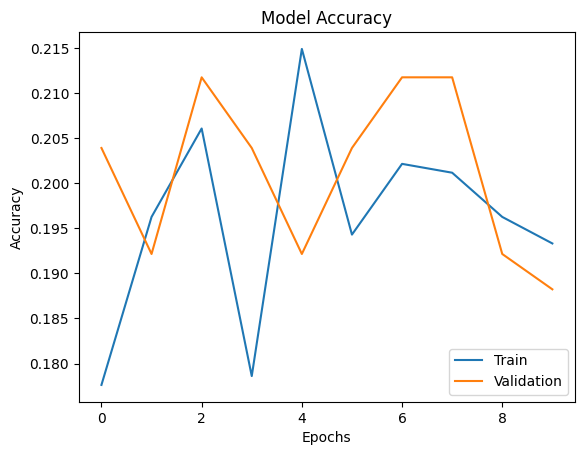

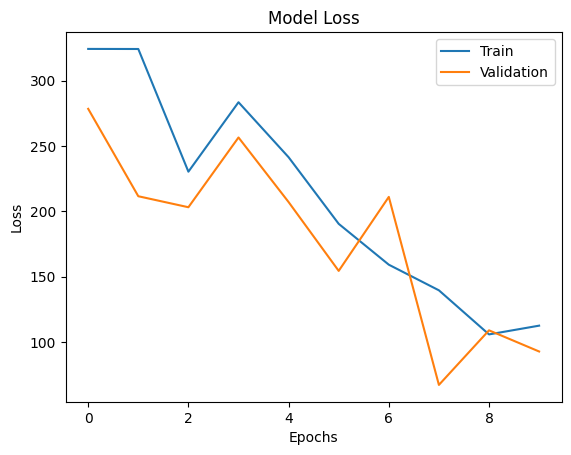

8/8 [==============================] - 5s 243ms/step
Class: P1
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Class: P2
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Class: P3
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Class: P4
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Class: P5
Precision: 0.1882
Recall: 1.0000
F1-score: 0.3168


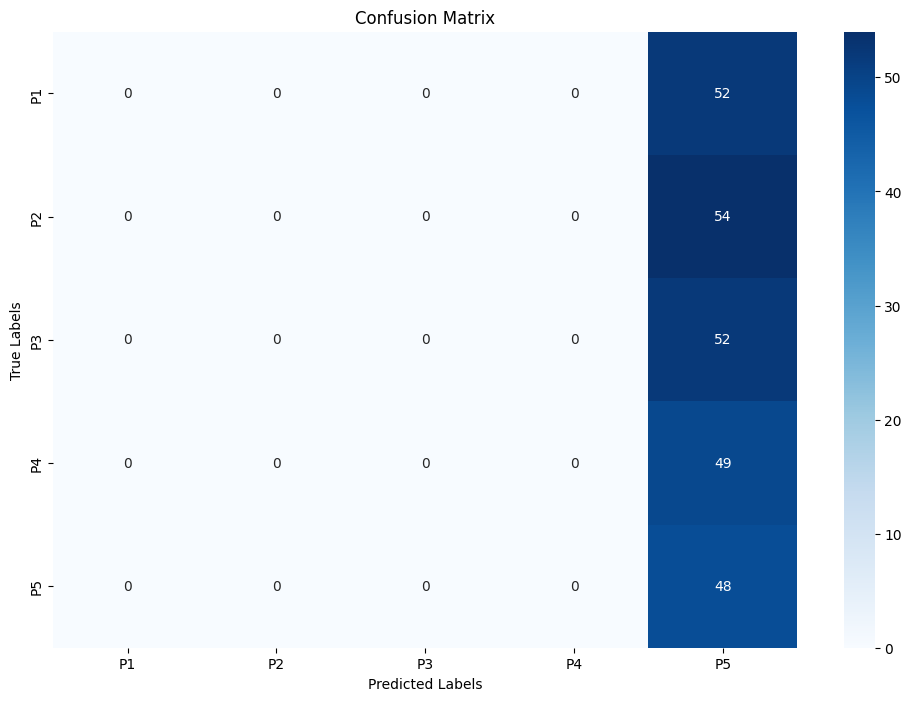

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 3000)]               0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 3000, 128)            3906944   ['input_5[0][0]']             
                                                                                                  
 bidirectional_8 (Bidirecti  (None, 3000, 128)            74496     ['embedding_4[0][0]']         
 onal)                                                                                            
                                                                                                  
 attention_8 (Attention)     (None, 3000, 128)            0         ['bidirectional_8[0][0]'

In [ ]:
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import ADASYN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.layers import Attention, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
import seaborn as sns  # Add this import

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Load CSV dataset
data = pd.read_csv('/content/drive/MyDrive/Datasets/Equalised_eclipse_jdt_250each.csv')

# Count the number of samples for each class
class_counts = data['Priority'].value_counts()

# Find the class with the minimum number of samples
minority_class = class_counts.idxmin()

print("Minority class:", minority_class)
print(class_counts)


# Text preprocessing steps
def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase conversion
        text = text.lower()

        # Remove punctuation and special characters
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]
        text = ' '.join(tokens)

        # Stemming
        stemmer = PorterStemmer()
        tokens = text.split()
        tokens = [stemmer.stem(word) for word in tokens]
        text = ' '.join(tokens)

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        text = ' '.join(tokens)

    return text

# Apply text preprocessing to 'description' and 'title' columns
data['Description'] = data['Description'].apply(preprocess_text)
data['Title'] = data['Title'].apply(preprocess_text)

# Tokenize using DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_sequence_length = 3000

def tokenize_text(text):
    if isinstance(text, (str, int, float)):
        text = str(text)  # Convert text to string if it's not already

        tokens = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_sequence_length, padding='max_length', truncation=True)
        input_ids = tokens['input_ids']
        attention_mask = tokens['attention_mask']
    else:
        input_ids = []
        attention_mask = []
    return input_ids, attention_mask

# Apply tokenization to 'Description' and 'Title' columns
data['Description'] = data['Description'].apply(tokenize_text)
data['Title'] = data['Title'].apply(tokenize_text)

# Convert tokenized data to numpy arrays
input_ids = np.array([item[0] for item in data['Description']])
attention_masks = np.array([item[1] for item in data['Description']])

# Reshape input IDs and attention masks to have at most 2 dimensions
input_ids = input_ids.reshape(input_ids.shape[0], -1)
attention_masks = attention_masks.reshape(attention_masks.shape[0], -1)

# Concatenate input IDs and attention masks
X_input = np.concatenate((input_ids, attention_masks), axis=1)
y_input = data['Priority']

# # Apply ADASYN oversampling
# adasyn = ADASYN()
# X_resampled, y_resampled = adasyn.fit_resample(X_input, y_input)

# # Apply ADASYN oversampling
# if len(class_counts) > 1 and class_counts.iloc[-1] < class_counts.iloc[0]:
#     adasyn = ADASYN(n_neighbors=5, sampling_strategy='minority')
#     X_resampled, y_resampled = adasyn.fit_resample(X_input, y_input)
# else:
#     X_resampled, y_resampled = X_input, y_input

X_resampled, y_resampled = X_input, y_input

# Separate the resampled input IDs and attention masks
input_ids_resampled = X_resampled[:, :max_sequence_length]
attention_masks_resampled = X_resampled[:, max_sequence_length:]

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(input_ids_resampled, y_resampled, test_size=0.2, random_state=42)

# Pad sequences
X_train = pad_sequences(X_train, maxlen=max_sequence_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_sequence_length, padding='post', truncating='post')

from sklearn.preprocessing import LabelEncoder

# Encode string labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to categorical
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train_encoded, num_classes)
y_test = to_categorical(y_test_encoded, num_classes)

# Build HAN model
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(len(tokenizer.get_vocab()) + 1, 128)(input_layer)
word_encoder = Bidirectional(GRU(64, return_sequences=True))(embedding_layer)
word_attention = Attention()([word_encoder, word_encoder])
word_flatten = Flatten()(word_attention)
word_dense = Dense(64)(word_flatten)
word_repeat = RepeatVector(max_sequence_length)(word_dense)
sentence_encoder = Bidirectional(GRU(64, return_sequences=True))(word_repeat)
sentence_attention = Attention()([sentence_encoder, sentence_encoder])
sentence_flatten = Flatten()(sentence_attention)
sentence_dense = Dense(64)(sentence_flatten)
output_layer = Dense(num_classes, activation='softmax')(sentence_dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10, callbacks=[early_stopping])

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Calculate precision, recall, and F1-score for each class
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_original = label_encoder.inverse_transform(y_test_encoded)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

# Calculate precision, recall, and F1-score with zero_division parameter
precision = precision_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_, zero_division=0)
recall = recall_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_, zero_division=0)
f1 = f1_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_, zero_division=0)

# Display precision, recall, and F1-score for each class
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1[i]:.4f}")
    print("="*30)


# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=label_encoder.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print model summary
model.summary()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Minority class: P1
P4    263
P3    256
P2    252
P5    252
P1    251
Name: Priority, dtype: int64
Epoch 1/10
32/32 [==============================] - 41s 936ms/step - loss: 430.0794 - accuracy: 0.1825 - val_loss: 396.2027 - val_accuracy: 0.2118
Epoch 2/10
32/32 [==============================] - 28s 876ms/step - loss: 284.5743 - accuracy: 0.2237 - val_loss: 348.6028 - val_accuracy: 0.1922
Epoch 3/10
32/32 [==============================] - 27s 856ms/step - loss: 230.6165 - accuracy: 0.1973 - val_loss: 230.7856 - val_accuracy: 0.2118
Epoch 4/10
32/32 [==============================] - 27s 855ms/step - loss: 395.5651 - accuracy: 0.2080 - val_loss: 261.2802 - val_accuracy: 0.1922
Epoch 5/10
32/32 [==============================] - 27s 843ms/step - loss: 296.1765 - accuracy: 0.1914 - val_loss: 430.3470 - val_accuracy: 0.2039
Epoch 6/10
32/32 [====================

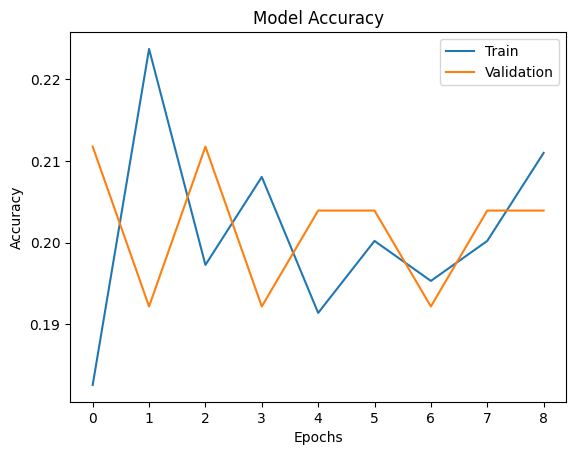

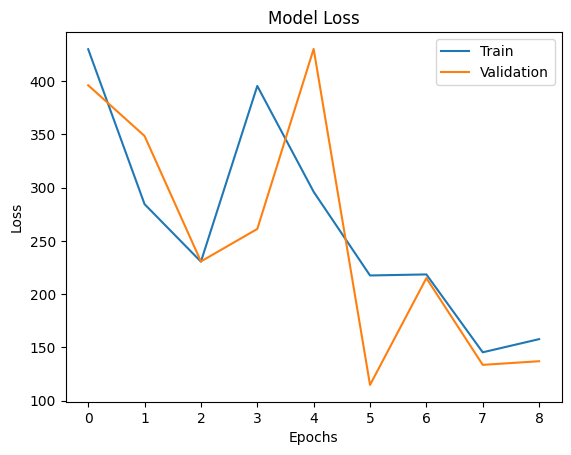

8/8 [==============================] - 4s 245ms/step
Class: P1
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Class: P2
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Class: P3
Precision: 0.2039
Recall: 1.0000
F1-score: 0.3388
Class: P4
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Class: P5
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


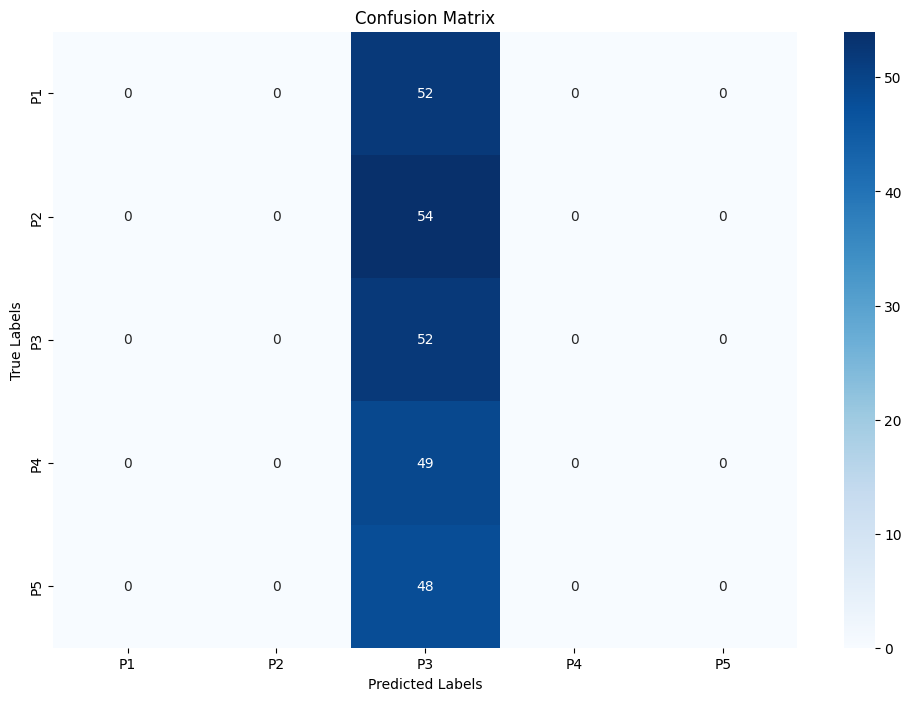

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 3000)]               0         []                            
                                                                                                  
 embedding_9 (Embedding)     (None, 3000, 128)            3906944   ['input_10[0][0]']            
                                                                                                  
 bidirectional_18 (Bidirect  (None, 3000, 128)            74496     ['embedding_9[0][0]']         
 ional)                                                                                           
                                                                                                  
 attention_18 (Attention)    (None, 3000, 128)            0         ['bidirectional_18[0][0]

In [ ]:
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import ADASYN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.layers import Attention, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
import seaborn as sns  # Add this import

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Load CSV dataset
data = pd.read_csv('/content/drive/MyDrive/Datasets/Equalised_eclipse_jdt_250each.csv')

# Count the number of samples for each class
class_counts = data['Priority'].value_counts()

# Find the class with the minimum number of samples
minority_class = class_counts.idxmin()

print("Minority class:", minority_class)
print(class_counts)


# Text preprocessing steps
def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase conversion
        text = text.lower()

        # Remove punctuation and special characters
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]
        text = ' '.join(tokens)

        # Stemming
        stemmer = PorterStemmer()
        tokens = text.split()
        tokens = [stemmer.stem(word) for word in tokens]
        text = ' '.join(tokens)

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        text = ' '.join(tokens)

    return text

# Apply text preprocessing to 'description' and 'title' columns
data['Description'] = data['Description'].apply(preprocess_text)
data['Title'] = data['Title'].apply(preprocess_text)

# Tokenize using DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_sequence_length = 3000

def tokenize_text(text):
    if isinstance(text, (str, int, float)):
        text = str(text)  # Convert text to string if it's not already

        tokens = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_sequence_length, padding='max_length', truncation=True)
        input_ids = tokens['input_ids']
        attention_mask = tokens['attention_mask']
    else:
        input_ids = []
        attention_mask = []
    return input_ids, attention_mask

# Apply tokenization to 'Description' and 'Title' columns
data['Description'] = data['Description'].apply(tokenize_text)
data['Title'] = data['Title'].apply(tokenize_text)

# Convert tokenized data to numpy arrays
input_ids = np.array([item[0] for item in data['Description']])
attention_masks = np.array([item[1] for item in data['Description']])

# Reshape input IDs and attention masks to have at most 2 dimensions
input_ids = input_ids.reshape(input_ids.shape[0], -1)
attention_masks = attention_masks.reshape(attention_masks.shape[0], -1)

# Concatenate input IDs and attention masks
X_input = np.concatenate((input_ids, attention_masks), axis=1)
y_input = data['Priority']

# # Apply ADASYN oversampling
# adasyn = ADASYN()
# X_resampled, y_resampled = adasyn.fit_resample(X_input, y_input)

# # Apply ADASYN oversampling
# if len(class_counts) > 1 and class_counts.iloc[-1] < class_counts.iloc[0]:
#     adasyn = ADASYN(n_neighbors=5, sampling_strategy='minority')
#     X_resampled, y_resampled = adasyn.fit_resample(X_input, y_input)
# else:
#     X_resampled, y_resampled = X_input, y_input

X_resampled, y_resampled = X_input, y_input

# Separate the resampled input IDs and attention masks
input_ids_resampled = X_resampled[:, :max_sequence_length]
attention_masks_resampled = X_resampled[:, max_sequence_length:]

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(input_ids_resampled, y_resampled, test_size=0.2, random_state=42)

# Pad sequences
X_train = pad_sequences(X_train, maxlen=max_sequence_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_sequence_length, padding='post', truncating='post')

from sklearn.preprocessing import LabelEncoder

# Encode string labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to categorical
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train_encoded, num_classes)
y_test = to_categorical(y_test_encoded, num_classes)

# Build HAN model
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(len(tokenizer.get_vocab()) + 1, 128)(input_layer)
word_encoder = Bidirectional(GRU(64, return_sequences=True))(embedding_layer)
word_attention = Attention()([word_encoder, word_encoder])
word_flatten = Flatten()(word_attention)
word_dense = Dense(64)(word_flatten)
word_repeat = RepeatVector(max_sequence_length)(word_dense)
sentence_encoder = Bidirectional(GRU(64, return_sequences=True))(word_repeat)
sentence_attention = Attention()([sentence_encoder, sentence_encoder])
sentence_flatten = Flatten()(sentence_attention)
sentence_dense = Dense(64)(sentence_flatten)
output_layer = Dense(num_classes, activation='softmax')(sentence_dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10, callbacks=[early_stopping])

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Calculate precision, recall, and F1-score for each class
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_original = label_encoder.inverse_transform(y_test_encoded)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

# Calculate precision, recall, and F1-score with zero_division parameter
precision = precision_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_, zero_division=0)
recall = recall_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_, zero_division=0)
f1 = f1_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_, zero_division=0)

# Display precision, recall, and F1-score for each class
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1[i]:.4f}")
    print("="*30)


# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=label_encoder.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print model summary
model.summary()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Minority class: P1
P4    263
P3    256
P2    252
P5    252
P1    251
Name: Priority, dtype: int64
Epoch 1/10
32/32 [==============================] - 39s 937ms/step - loss: 442.4734 - accuracy: 0.1904 - val_loss: 625.4825 - val_accuracy: 0.2039
Epoch 2/10
32/32 [==============================] - 30s 963ms/step - loss: 310.1262 - accuracy: 0.2071 - val_loss: 152.3760 - val_accuracy: 0.2118
Epoch 3/10
32/32 [==============================] - 33s 1s/step - loss: 325.8586 - accuracy: 0.2090 - val_loss: 437.2795 - val_accuracy: 0.2039
Epoch 4/10
32/32 [==============================] - 26s 818ms/step - loss: 289.0653 - accuracy: 0.2080 - val_loss: 96.8402 - val_accuracy: 0.1922
Epoch 5/10
32/32 [==============================] - 27s 858ms/step - loss: 211.6233 - accuracy: 0.1914 - val_loss: 262.3114 - val_accuracy: 0.2039
Epoch 6/10
32/32 [========================

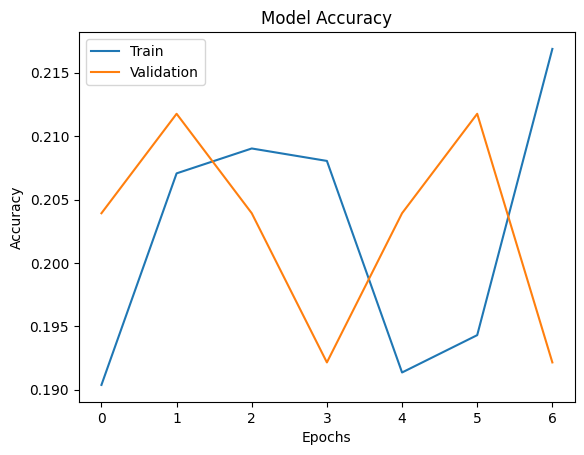

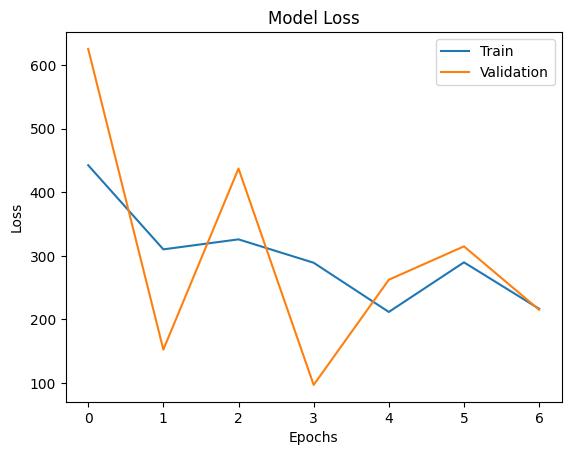

8/8 [==============================] - 4s 242ms/step
Class: P1
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Class: P2
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Class: P3
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Class: P4
Precision: 0.1922
Recall: 1.0000
F1-score: 0.3224
Class: P5
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


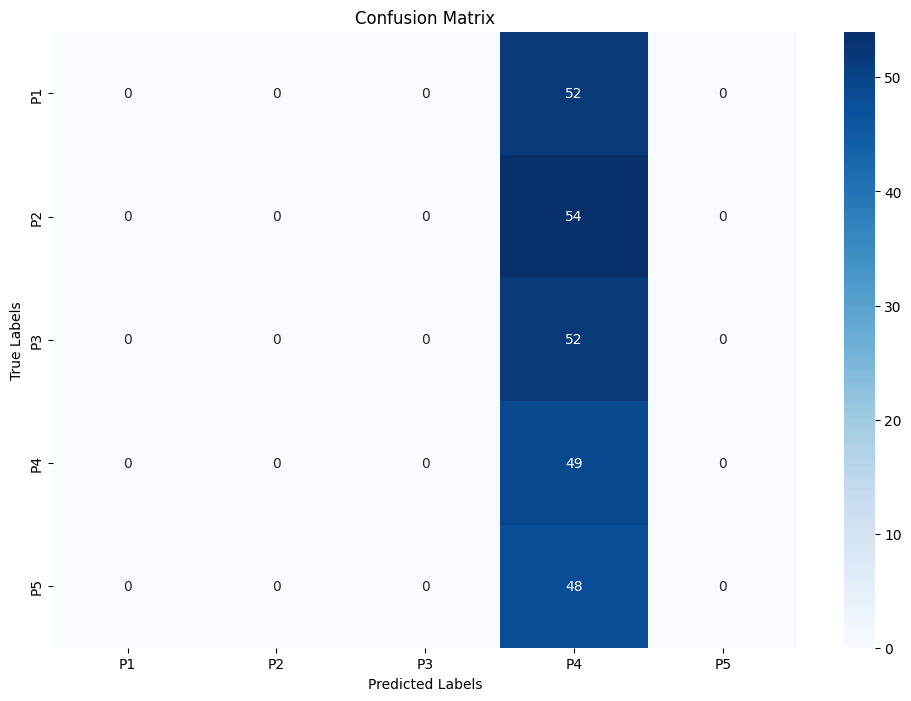

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 3000)]               0         []                            
                                                                                                  
 embedding_16 (Embedding)    (None, 3000, 128)            3906944   ['input_17[0][0]']            
                                                                                                  
 bidirectional_32 (Bidirect  (None, 3000, 128)            74496     ['embedding_16[0][0]']        
 ional)                                                                                           
                                                                                                  
 attention_32 (Attention)    (None, 3000, 128)            0         ['bidirectional_32[0][0

In [ ]:
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import ADASYN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.layers import Attention, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
import seaborn as sns  # Add this import

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Load CSV dataset
data = pd.read_csv('/content/drive/MyDrive/Datasets/Equalised_eclipse_jdt_250each.csv')

# Count the number of samples for each class
class_counts = data['Priority'].value_counts()

# Find the class with the minimum number of samples
minority_class = class_counts.idxmin()

print("Minority class:", minority_class)
print(class_counts)


# Text preprocessing steps
def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase conversion
        text = text.lower()

        # Remove punctuation and special characters
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]
        text = ' '.join(tokens)

        # Stemming
        stemmer = PorterStemmer()
        tokens = text.split()
        tokens = [stemmer.stem(word) for word in tokens]
        text = ' '.join(tokens)

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        text = ' '.join(tokens)

    return text

# Apply text preprocessing to 'description' and 'title' columns
data['Description'] = data['Description'].apply(preprocess_text)
data['Title'] = data['Title'].apply(preprocess_text)

# Tokenize using DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_sequence_length = 3000

def tokenize_text(text):
    if isinstance(text, (str, int, float)):
        text = str(text)  # Convert text to string if it's not already

        tokens = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_sequence_length, padding='max_length', truncation=True)
        input_ids = tokens['input_ids']
        attention_mask = tokens['attention_mask']
    else:
        input_ids = []
        attention_mask = []
    return input_ids, attention_mask

# Apply tokenization to 'Description' and 'Title' columns
data['Description'] = data['Description'].apply(tokenize_text)
data['Title'] = data['Title'].apply(tokenize_text)

# Convert tokenized data to numpy arrays
input_ids = np.array([item[0] for item in data['Description']])
attention_masks = np.array([item[1] for item in data['Description']])

# Reshape input IDs and attention masks to have at most 2 dimensions
input_ids = input_ids.reshape(input_ids.shape[0], -1)
attention_masks = attention_masks.reshape(attention_masks.shape[0], -1)

# Concatenate input IDs and attention masks
X_input = np.concatenate((input_ids, attention_masks), axis=1)
y_input = data['Priority']

# # Apply ADASYN oversampling
# adasyn = ADASYN()
# X_resampled, y_resampled = adasyn.fit_resample(X_input, y_input)

# # Apply ADASYN oversampling
# if len(class_counts) > 1 and class_counts.iloc[-1] < class_counts.iloc[0]:
#     adasyn = ADASYN(n_neighbors=5, sampling_strategy='minority')
#     X_resampled, y_resampled = adasyn.fit_resample(X_input, y_input)
# else:
#     X_resampled, y_resampled = X_input, y_input

X_resampled, y_resampled = X_input, y_input

# Separate the resampled input IDs and attention masks
input_ids_resampled = X_resampled[:, :max_sequence_length]
attention_masks_resampled = X_resampled[:, max_sequence_length:]

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(input_ids_resampled, y_resampled, test_size=0.2, random_state=42)

# Pad sequences
X_train = pad_sequences(X_train, maxlen=max_sequence_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_sequence_length, padding='post', truncating='post')

from sklearn.preprocessing import LabelEncoder

# Encode string labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to categorical
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train_encoded, num_classes)
y_test = to_categorical(y_test_encoded, num_classes)

# Build HAN model
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(len(tokenizer.get_vocab()) + 1, 128)(input_layer)
word_encoder = Bidirectional(GRU(64, return_sequences=True))(embedding_layer)
word_attention = Attention()([word_encoder, word_encoder])
word_flatten = Flatten()(word_attention)
word_dense = Dense(64)(word_flatten)
word_repeat = RepeatVector(max_sequence_length)(word_dense)
sentence_encoder = Bidirectional(GRU(64, return_sequences=True))(word_repeat)
sentence_attention = Attention()([sentence_encoder, sentence_encoder])
sentence_flatten = Flatten()(sentence_attention)
sentence_dense = Dense(64)(sentence_flatten)
output_layer = Dense(num_classes, activation='softmax')(sentence_dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10, callbacks=[early_stopping])

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Calculate precision, recall, and F1-score for each class
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_original = label_encoder.inverse_transform(y_test_encoded)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

# Calculate precision, recall, and F1-score with zero_division parameter
precision = precision_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_, zero_division=0)
recall = recall_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_, zero_division=0)
f1 = f1_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_, zero_division=0)

# Display precision, recall, and F1-score for each class
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1[i]:.4f}")
    print("="*30)


# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=label_encoder.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print model summary
model.summary()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

In [ ]:
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import ADASYN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.layers import Attention, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
import seaborn as sns  # Add this import

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Load CSV dataset
data = pd.read_csv('/content/drive/MyDrive/Datasets/Equalised_eclipse_jdt_250each.csv')

# Count the number of samples for each class
class_counts = data['Priority'].value_counts()

# Find the class with the minimum number of samples
minority_class = class_counts.idxmin()

print("Minority class:", minority_class)
print(class_counts)


# Text preprocessing steps
def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase conversion
        text = text.lower()

        # Remove punctuation and special characters
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]
        text = ' '.join(tokens)

        # Stemming
        stemmer = PorterStemmer()
        tokens = text.split()
        tokens = [stemmer.stem(word) for word in tokens]
        text = ' '.join(tokens)

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        text = ' '.join(tokens)

    return text

# Apply text preprocessing to 'description' and 'title' columns
data['Description'] = data['Description'].apply(preprocess_text)
data['Title'] = data['Title'].apply(preprocess_text)

# Tokenize using DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_sequence_length = 3000

def tokenize_text(text):
    if isinstance(text, (str, int, float)):
        text = str(text)  # Convert text to string if it's not already

        tokens = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_sequence_length, padding='max_length', truncation=True)
        input_ids = tokens['input_ids']
        attention_mask = tokens['attention_mask']
    else:
        input_ids = []
        attention_mask = []
    return input_ids, attention_mask

# Apply tokenization to 'Description' and 'Title' columns
data['Description'] = data['Description'].apply(tokenize_text)
data['Title'] = data['Title'].apply(tokenize_text)

# Convert tokenized data to numpy arrays
input_ids = np.array([item[0] for item in data['Description']])
attention_masks = np.array([item[1] for item in data['Description']])

# Reshape input IDs and attention masks to have at most 2 dimensions
input_ids = input_ids.reshape(input_ids.shape[0], -1)
attention_masks = attention_masks.reshape(attention_masks.shape[0], -1)

# Concatenate input IDs and attention masks
X_input = np.concatenate((input_ids, attention_masks), axis=1)
y_input = data['Priority']

# # Apply ADASYN oversampling
# adasyn = ADASYN()
# X_resampled, y_resampled = adasyn.fit_resample(X_input, y_input)

# # Apply ADASYN oversampling
# if len(class_counts) > 1 and class_counts.iloc[-1] < class_counts.iloc[0]:
#     adasyn = ADASYN(n_neighbors=5, sampling_strategy='minority')
#     X_resampled, y_resampled = adasyn.fit_resample(X_input, y_input)
# else:
#     X_resampled, y_resampled = X_input, y_input

X_resampled, y_resampled = X_input, y_input

# Separate the resampled input IDs and attention masks
input_ids_resampled = X_resampled[:, :max_sequence_length]
attention_masks_resampled = X_resampled[:, max_sequence_length:]

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(input_ids_resampled, y_resampled, test_size=0.2, random_state=42)

# Pad sequences
X_train = pad_sequences(X_train, maxlen=max_sequence_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_sequence_length, padding='post', truncating='post')

from sklearn.preprocessing import LabelEncoder

# Encode string labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to categorical
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train_encoded, num_classes)
y_test = to_categorical(y_test_encoded, num_classes)

# Build HAN model
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(len(tokenizer.get_vocab()) + 1, 128)(input_layer)
word_encoder = Bidirectional(GRU(64, return_sequences=True))(embedding_layer)
word_attention = Attention()([word_encoder, word_encoder])
word_flatten = Flatten()(word_attention)
word_dense = Dense(64)(word_flatten)
word_repeat = RepeatVector(max_sequence_length)(word_dense)
sentence_encoder = Bidirectional(GRU(64, return_sequences=True))(word_repeat)
sentence_attention = Attention()([sentence_encoder, sentence_encoder])
sentence_flatten = Flatten()(sentence_attention)
sentence_dense = Dense(64)(sentence_flatten)
output_layer = Dense(num_classes, activation='softmax')(sentence_dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10, callbacks=[early_stopping])

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Calculate precision, recall, and F1-score for each class
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_original = label_encoder.inverse_transform(y_test_encoded)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

# Calculate precision, recall, and F1-score with zero_division parameter
precision = precision_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_, zero_division=0)
recall = recall_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_, zero_division=0)
f1 = f1_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_, zero_division=0)

# Display precision, recall, and F1-score for each class
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1[i]:.4f}")
    print("="*30)


# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=label_encoder.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print model summary
model.summary()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.1921568661928177


## Firefox Data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Minority class: P5
P2    451
P4    381
P3    323
P1    308
P5    191
Name: Priority, dtype: int64
Epoch 1/10
42/42 [==============================] - 49s 918ms/step - loss: 395.2267 - accuracy: 0.1943 - val_loss: 189.6154 - val_accuracy: 0.1601
Epoch 2/10
42/42 [==============================] - 39s 920ms/step - loss: 311.5133 - accuracy: 0.2086 - val_loss: 234.8808 - val_accuracy: 0.1601
Epoch 3/10
42/42 [==============================] - 35s 844ms/step - loss: 176.1053 - accuracy: 0.1882 - val_loss: 306.1866 - val_accuracy: 0.1601
Epoch 4/10
42/42 [==============================] - 38s 903ms/step - loss: 268.5731 - accuracy: 0.2063 - val_loss: 278.8336 - val_accuracy: 0.1903


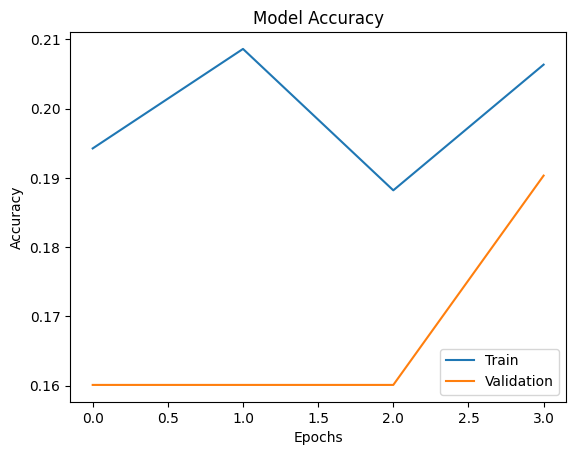

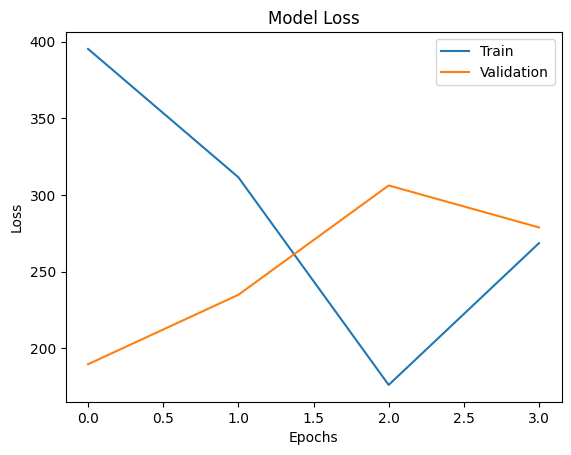

11/11 [==============================] - 4s 237ms/step
Class: P1
Precision: 0.1601
Recall: 1.0000
F1-score: 0.2760
Class: P2
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Class: P3
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Class: P4
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Class: P5
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


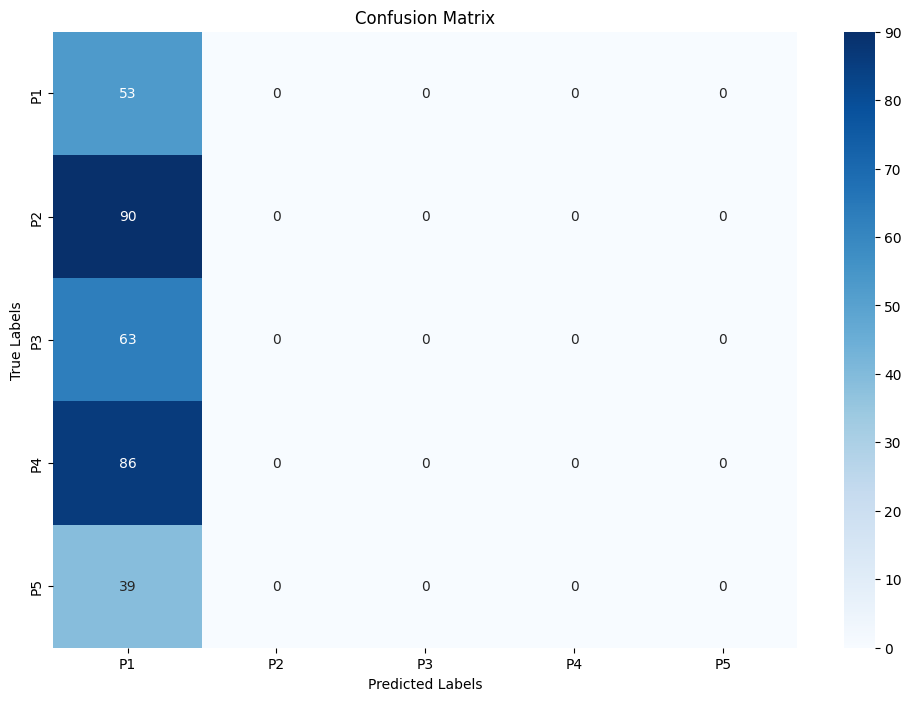

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 3000)]               0         []                            
                                                                                                  
 embedding_18 (Embedding)    (None, 3000, 128)            3906944   ['input_19[0][0]']            
                                                                                                  
 bidirectional_36 (Bidirect  (None, 3000, 128)            74496     ['embedding_18[0][0]']        
 ional)                                                                                           
                                                                                                  
 attention_36 (Attention)    (None, 3000, 128)            0         ['bidirectional_36[0][0

In [ ]:
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import ADASYN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.layers import Attention, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
import seaborn as sns  # Add this import

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Load CSV dataset
data = pd.read_csv('/content/drive/MyDrive/Datasets/mozilla_firefox_small.csv')

# Remove rows where 'Priority' column is empty or '-'
data = data[data['Priority'].notnull() & (data['Priority'] != '-')]

# Count the number of samples for each class
class_counts = data['Priority'].value_counts()

# Find the class with the minimum number of samples
minority_class = class_counts.idxmin()

print("Minority class:", minority_class)
print(class_counts)


# Text preprocessing steps
def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase conversion
        text = text.lower()

        # Remove punctuation and special characters
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]
        text = ' '.join(tokens)

        # Stemming
        stemmer = PorterStemmer()
        tokens = text.split()
        tokens = [stemmer.stem(word) for word in tokens]
        text = ' '.join(tokens)

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        text = ' '.join(tokens)

    return text

# Apply text preprocessing to 'description' and 'title' columns
data['Description'] = data['Description'].apply(preprocess_text)
data['Title'] = data['Title'].apply(preprocess_text)

# Tokenize using DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_sequence_length = 3000

def tokenize_text(text):
    if isinstance(text, (str, int, float)):
        text = str(text)  # Convert text to string if it's not already

        tokens = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_sequence_length, padding='max_length', truncation=True)
        input_ids = tokens['input_ids']
        attention_mask = tokens['attention_mask']
    else:
        input_ids = []
        attention_mask = []
    return input_ids, attention_mask

# Apply tokenization to 'Description' and 'Title' columns
data['Description'] = data['Description'].apply(tokenize_text)
data['Title'] = data['Title'].apply(tokenize_text)

# Convert tokenized data to numpy arrays
input_ids = np.array([item[0] for item in data['Description']])
attention_masks = np.array([item[1] for item in data['Description']])

# Reshape input IDs and attention masks to have at most 2 dimensions
input_ids = input_ids.reshape(input_ids.shape[0], -1)
attention_masks = attention_masks.reshape(attention_masks.shape[0], -1)

# Concatenate input IDs and attention masks
X_input = np.concatenate((input_ids, attention_masks), axis=1)
y_input = data['Priority']

# # Apply ADASYN oversampling
# adasyn = ADASYN()
# X_resampled, y_resampled = adasyn.fit_resample(X_input, y_input)

# # Apply ADASYN oversampling
# if len(class_counts) > 1 and class_counts.iloc[-1] < class_counts.iloc[0]:
#     adasyn = ADASYN(n_neighbors=5, sampling_strategy='minority')
#     X_resampled, y_resampled = adasyn.fit_resample(X_input, y_input)
# else:
#     X_resampled, y_resampled = X_input, y_input

X_resampled, y_resampled = X_input, y_input

# Separate the resampled input IDs and attention masks
input_ids_resampled = X_resampled[:, :max_sequence_length]
attention_masks_resampled = X_resampled[:, max_sequence_length:]

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(input_ids_resampled, y_resampled, test_size=0.2, random_state=42)

# Pad sequences
X_train = pad_sequences(X_train, maxlen=max_sequence_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_sequence_length, padding='post', truncating='post')

from sklearn.preprocessing import LabelEncoder

# Encode string labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to categorical
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train_encoded, num_classes)
y_test = to_categorical(y_test_encoded, num_classes)

# Build HAN model
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(len(tokenizer.get_vocab()) + 1, 128)(input_layer)
word_encoder = Bidirectional(GRU(64, return_sequences=True))(embedding_layer)
word_attention = Attention()([word_encoder, word_encoder])
word_flatten = Flatten()(word_attention)
word_dense = Dense(64)(word_flatten)
word_repeat = RepeatVector(max_sequence_length)(word_dense)
sentence_encoder = Bidirectional(GRU(64, return_sequences=True))(word_repeat)
sentence_attention = Attention()([sentence_encoder, sentence_encoder])
sentence_flatten = Flatten()(sentence_attention)
sentence_dense = Dense(64)(sentence_flatten)
output_layer = Dense(num_classes, activation='softmax')(sentence_dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10, callbacks=[early_stopping])

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Calculate precision, recall, and F1-score for each class
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_original = label_encoder.inverse_transform(y_test_encoded)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

# Calculate precision, recall, and F1-score with zero_division parameter
precision = precision_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_, zero_division=0)
recall = recall_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_, zero_division=0)
f1 = f1_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_, zero_division=0)

# Display precision, recall, and F1-score for each class
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1[i]:.4f}")
    print("="*30)


# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=label_encoder.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print model summary
model.summary()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.5 MB/s eta 0:00:00


In [ ]:
pip install tensorflow

### testing with SMOTE

In [ ]:
pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [ ]:
pip install -upgrade keras


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/drive
Minority class: P5
P2    451
P4    381
P3    323
P1    308
P5    191
Name: Priority, dtype: int64


Epoch 1/10
57/57 [==============================] - 70s 962ms/step - loss: 378.0255 - accuracy: 0.2145 - val_loss: 543.8755 - val_accuracy: 0.2018
Epoch 2/10
57/57 [==============================] - 51s 891ms/step - loss: 341.0031 - accuracy: 0.1957 - val_loss: 177.7097 - val_accuracy: 0.2018
Epoch 3/10
57/57 [==============================] - 52s 917ms/step - loss: 188.7737 - accuracy: 0.1973 - val_loss: 158.9226 - val_accuracy: 0.2550
Epoch 4/10
57/57 [==============================] - 52s 923ms/step - loss: 190.2714 - accuracy: 0.2018 - val_loss: 158.3665 - val_accuracy: 0.1885
Epoch 5/10
57/57 [==============================] - 50s 870ms/step - loss: 212.5833 - accuracy: 0.1935 - val_loss: 195.3148 - val_accuracy: 0.2550
Epoch 6/10
57/57 [==============================] - 49s 866ms/step - loss: 177.7301 - accuracy: 0.1912 - val_loss: 125.6611 - val_accuracy: 0.2550
Epoch 7/10
57/57 [==============================] - 50s 873ms/step - loss: 119.6210 - accuracy: 0.2040 - val_loss: 169

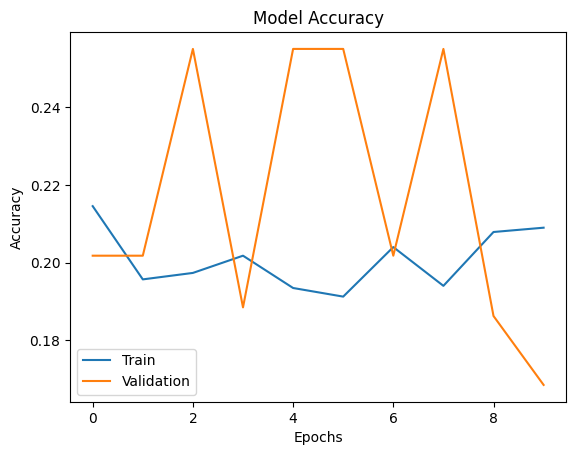

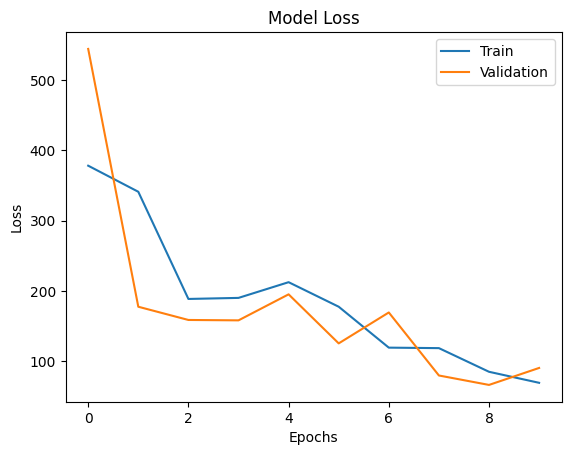

15/15 [==============================] - 5s 227ms/step
Class: P1
Precision: 0.1685
Recall: 1.0000
F1-score: 0.2884
Class: P2
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Class: P3
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Class: P4
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Class: P5
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000


In [ ]:
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.layers import Attention, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
import seaborn as sns  # Add this import

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Load CSV dataset
data = pd.read_csv('/content/drive/MyDrive/Datasets/mozilla_firefox_small.csv')

# Remove rows where 'Priority' column is empty or '-'
data = data[data['Priority'].notnull() & (data['Priority'] != '-')]

# Count the number of samples for each class
class_counts = data['Priority'].value_counts()

# Find the class with the minimum number of samples
minority_class = class_counts.idxmin()

print("Minority class:", minority_class)
print(class_counts)

# Text preprocessing steps
def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase conversion
        text = text.lower()

        # Remove punctuation and special characters
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]
        text = ' '.join(tokens)

        # Stemming
        stemmer = PorterStemmer()
        tokens = text.split()
        tokens = [stemmer.stem(word) for word in tokens]
        text = ' '.join(tokens)

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        text = ' '.join(tokens)

    return text

# Apply text preprocessing to 'description' and 'title' columns
data['Description'] = data['Description'].apply(preprocess_text)
data['Title'] = data['Title'].apply(preprocess_text)

# Tokenize using DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_sequence_length = 3000

def tokenize_text(text):
    if isinstance(text, (str, int, float)):
        text = str(text)  # Convert text to string if it's not already

        tokens = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_sequence_length, padding='max_length', truncation=True)
        input_ids = tokens['input_ids']
        attention_mask = tokens['attention_mask']
    else:
        input_ids = []
        attention_mask = []
    return input_ids, attention_mask

# Apply tokenization to 'Description' and 'Title' columns
data['Description'] = data['Description'].apply(tokenize_text)
data['Title'] = data['Title'].apply(tokenize_text)

# Convert tokenized data to numpy arrays
input_ids = np.array([item[0] for item in data['Description']])
attention_masks = np.array([item[1] for item in data['Description']])

# Reshape input IDs and attention masks to have at most 2 dimensions
input_ids = input_ids.reshape(input_ids.shape[0], -1)
attention_masks = attention_masks.reshape(attention_masks.shape[0], -1)

# Concatenate input IDs and attention masks
X_input = np.concatenate((input_ids, attention_masks), axis=1)
y_input = data['Priority']

# Apply SMOTE oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_input, y_input)

# Separate the resampled input IDs and attention masks
input_ids_resampled = X_resampled[:, :max_sequence_length]
attention_masks_resampled = X_resampled[:, max_sequence_length:]

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(input_ids_resampled, y_resampled, test_size=0.2, random_state=42)

# Pad sequences
X_train = pad_sequences(X_train, maxlen=max_sequence_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_sequence_length, padding='post', truncating='post')

from sklearn.preprocessing import LabelEncoder

# Encode string labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to categorical
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train_encoded, num_classes)
y_test = to_categorical(y_test_encoded, num_classes)

# Build HAN model
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(len(tokenizer.get_vocab()) + 1, 128)(input_layer)
word_encoder = Bidirectional(GRU(64, return_sequences=True))(embedding_layer)
word_attention = Attention()([word_encoder, word_encoder])
word_flatten = Flatten()(word_attention)
word_dense = Dense(64)(word_flatten)
word_repeat = RepeatVector(max_sequence_length)(word_dense)
sentence_encoder = Bidirectional(GRU(64, return_sequences=True))(word_repeat)
sentence_attention = Attention()([sentence_encoder, sentence_encoder])
sentence_flatten = Flatten()(sentence_attention)
sentence_dense = Dense(64)(sentence_flatten)
output_layer = Dense(num_classes, activation='softmax')(sentence_dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10, callbacks=[early_stopping])

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Calculate precision, recall, and F1-score for each class
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_original = label_encoder.inverse_transform(y_test_encoded)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

# Calculate precision, recall, and F1-score with zero_division parameter
precision = precision_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_, zero_division=0)
recall = recall_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_, zero_division=0)
f1 = f1_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_, zero_division=0)

# Display precision, recall, and F1-score for each class
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1[i]:.4f}")
    print("="*30)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=label_encoder.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print model summary
model.summary()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


#fine tune testing BERT

In [ ]:
import pandas as pd
import re
import string
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import seaborn as sns

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Load CSV dataset
data = pd.read_csv('/content/drive/MyDrive/Datasets/Equalised_eclipse_jdt_250each.csv')

# Count the number of samples for each class
class_counts = data['Priority'].value_counts()

# Find the class with the minimum number of samples
minority_class = class_counts.idxmin()

print("Minority class:", minority_class)
print(class_counts)

# Text preprocessing steps
def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase conversion
        text = text.lower()

        # Remove punctuation and special characters
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]
        text = ' '.join(tokens)

        # Stemming
        stemmer = PorterStemmer()
        tokens = text.split()
        tokens = [stemmer.stem(word) for word in tokens]
        text = ' '.join(tokens)

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        text = ' '.join(tokens)

    return text

# Apply text preprocessing to 'description' and 'title' columns
data['Description'] = data['Description'].apply(preprocess_text)
data['Title'] = data['Title'].apply(preprocess_text)

# Combine 'Title' and 'Description' columns
data['Text'] = data['Title'] + ' ' + data['Description']

# Tokenize using DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_sequence_length = 300

# Tokenize and pad sequences
X_encoded = tokenizer(list(data['Text']), truncation=True, padding='max_length', max_length=max_sequence_length, return_tensors='tf')

# Perform train-test split
X_train_encoded, X_test_encoded, y_train, y_test = train_test_split(X_encoded['input_ids'], data['Priority'], test_size=0.2, random_state=42)

# Convert labels to categorical
num_classes = len(data['Priority'].unique())
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Load DistilBERT model
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_classes)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=model.compute_loss,
              metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(X_train_encoded, y_train, validation_split=0.2, batch_size=32, epochs=10, callbacks=[early_stopping])

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Evaluate the model
loss, accuracy = model.evaluate(X_test_encoded, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Predict on test data
y_pred_probs = model.predict(X_test_encoded)[0]
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Calculate precision, recall, and F1-score with zero_division parameter
precision = precision_score(y_test, y_pred_classes, average=None, labels=data['Priority'].unique(), zero_division=0)
recall = recall_score(y_test, y_pred_classes, average=None, labels=data['Priority'].unique(), zero_division=0)
f1 = f1_score(y_test, y_pred_classes, average=None, labels=data['Priority'].unique(), zero_division=0)

# Display precision, recall, and F1-score for each class
for i, class_name in enumerate(data['Priority'].unique()):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1[i]:.4f}")
    print("="*30)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes, labels=data['Priority'].unique())
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=data['Priority'].unique(), yticklabels=data['Priority'].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print model summary
model.summary()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Minority class: P1
P4    263
P3    256
P2    252
P5    252
P1    251
Name: Priority, dtype: int64


TypeError: ignored

#GLove ADDED, no adasyn, self tuned equalised dataset

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Minority class: P1
P4    263
P3    256
P2    252
P5    252
P1    251
Name: Priority, dtype: int64
Epoch 1/10
32/32 [==============================] - 38s 754ms/step - loss: 261.1224 - accuracy: 0.2061 - val_loss: 93.3302 - val_accuracy: 0.2039
Epoch 2/10
32/32 [==============================] - 21s 661ms/step - loss: 37.9246 - accuracy: 0.2974 - val_loss: 23.2711 - val_accuracy: 0.2941
Epoch 3/10
32/32 [==============================] - 22s 696ms/step - loss: 15.6217 - accuracy: 0.3719 - val_loss: 18.1819 - val_accuracy: 0.2941
Epoch 4/10
32/32 [==============================] - 22s 688ms/step - loss: 8.2554 - accuracy: 0.4347 - val_loss: 9.5222 - val_accuracy: 0.3176
Epoch 5/10
32/32 [==============================] - 22s 696ms/step - loss: 5.0324 - accuracy: 0.5005 - val_loss: 9.8260 - val_accuracy: 0.2824
Epoch 6/10
32/32 [==============================] -

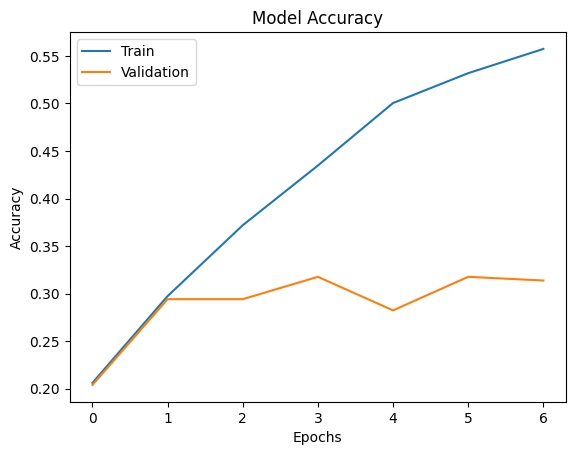

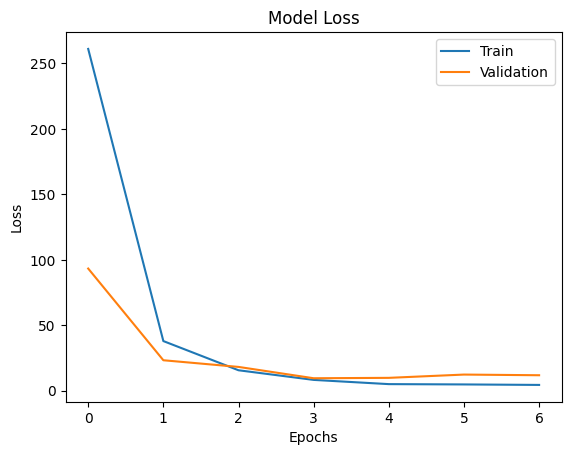

8/8 [==============================] - 3s 247ms/step
Class: P1
Precision: 0.5789
Recall: 0.2115
F1-score: 0.3099
Class: P2
Precision: 0.2258
Recall: 0.1296
F1-score: 0.1647
Class: P3
Precision: 0.3333
Recall: 0.2500
F1-score: 0.2857
Class: P4
Precision: 0.3714
Recall: 0.5306
F1-score: 0.4370
Class: P5
Precision: 0.2500
Recall: 0.5000
F1-score: 0.3333


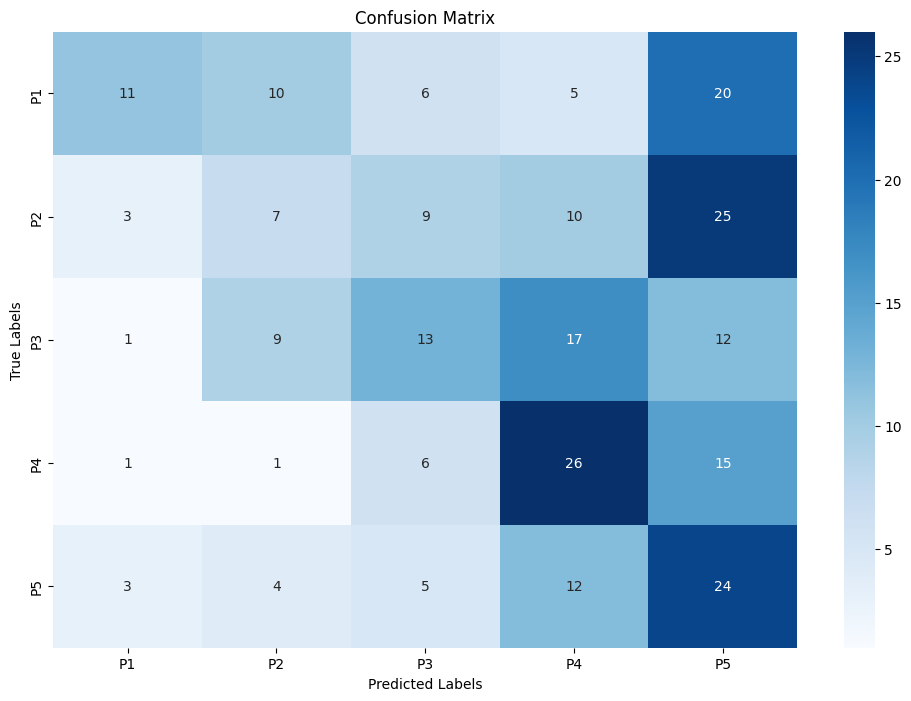

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 3000)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 3000, 100)    1198200     ['input_1[0][0]']                
                                                                                                  
 bidirectional (Bidirectional)  (None, 3000, 128)    63744       ['embedding[0][0]']              
                                                                                                  
 attention (Attention)          (None, 3000, 128)    0           ['bidirectional[0][0]',          
                                                                  'bidirectional[0][0]']      

In [ ]:
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import ADASYN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.layers import Attention, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
import seaborn as sns  # Add this import

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Load CSV dataset
data = pd.read_csv('/content/drive/MyDrive/Datasets/Equalised_eclipse_jdt_250each.csv')

# Count the number of samples for each class
class_counts = data['Priority'].value_counts()

# Find the class with the minimum number of samples
minority_class = class_counts.idxmin()

print("Minority class:", minority_class)
print(class_counts)


# Text preprocessing steps
def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase conversion
        text = text.lower()

        # Remove punctuation and special characters
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]
        text = ' '.join(tokens)

        # Stemming
        stemmer = PorterStemmer()
        tokens = text.split()
        tokens = [stemmer.stem(word) for word in tokens]
        text = ' '.join(tokens)

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        text = ' '.join(tokens)

    return text

# Apply text preprocessing to 'description' and 'title' columns
data['Description'] = data['Description'].apply(preprocess_text)
data['Title'] = data['Title'].apply(preprocess_text)

# Tokenize using Keras tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Description'] + ' ' + data['Title'])
max_sequence_length = 3000

# Convert text to sequences
X_sequences = tokenizer.texts_to_sequences(data['Description'] + ' ' + data['Title'])

# Pad sequences
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Separate input data and labels
X_input = X_padded
y_input = data['Priority']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, test_size=0.2, random_state=42)

from sklearn.preprocessing import LabelEncoder

# Encode string labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to categorical
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train_encoded, num_classes)
y_test = to_categorical(y_test_encoded, num_classes)

# Load pre-trained GloVe embeddings
glove_path = '/content/drive/MyDrive/Datasets/glove.6B.100d.txt'  # Specify the path to your GloVe embeddings file
embedding_dim = 100  # Change this according to the GloVe embeddings you're using

def create_glove_embedding_matrix(word_index, embedding_dim, glove_path):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    with open(glove_path, encoding='utf-8') as f:
        for line in f:
            word, embedding = line.split(maxsplit=1)
            if word in word_index:
                embedding_matrix[word_index[word]] = np.fromstring(embedding, sep=' ')
    return embedding_matrix

glove_embedding_matrix = create_glove_embedding_matrix(tokenizer.word_index, embedding_dim, glove_path)

# Build HAN model with GloVe embeddings
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[glove_embedding_matrix], trainable=False)(input_layer)
word_encoder = Bidirectional(GRU(64, return_sequences=True))(embedding_layer)
word_attention = Attention()([word_encoder, word_encoder])
word_flatten = Flatten()(word_attention)
word_dense = Dense(64)(word_flatten)
word_repeat = RepeatVector(max_sequence_length)(word_dense)
sentence_encoder = Bidirectional(GRU(64, return_sequences=True))(word_repeat)
sentence_attention = Attention()([sentence_encoder, sentence_encoder])
sentence_flatten = Flatten()(sentence_attention)
sentence_dense = Dense(64)(sentence_flatten)
output_layer = Dense(num_classes, activation='softmax')(sentence_dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10, callbacks=[early_stopping])


# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Calculate precision, recall, and F1-score for each class
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_original = label_encoder.inverse_transform(y_test_encoded)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

precision = precision_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_)
recall = recall_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_)
f1 = f1_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_)

# Display precision, recall, and F1-score for each class
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1[i]:.4f}")
    print("="*30)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=label_encoder.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print model summary
model.summary()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Glove , uneqalised, No Adasyn

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Minority class: P2
P3    712
P5    152
P4     64
P1     39
P2     33
Name: Priority, dtype: int64
Epoch 1/10
25/25 [==============================] - 26s 781ms/step - loss: 385.4400 - accuracy: 0.4475 - val_loss: 453.4373 - val_accuracy: 0.1400
Epoch 2/10
25/25 [==============================] - 17s 702ms/step - loss: 248.8270 - accuracy: 0.5263 - val_loss: 162.5701 - val_accuracy: 0.7500
Epoch 3/10
25/25 [==============================] - 18s 737ms/step - loss: 213.1168 - accuracy: 0.5475 - val_loss: 70.0137 - val_accuracy: 0.7150
Epoch 4/10
25/25 [==============================] - 18s 733ms/step - loss: 141.8711 - accuracy: 0.5850 - val_loss: 262.5076 - val_accuracy: 0.1700
Epoch 5/10
25/25 [==============================] - 18s 724ms/step - loss: 102.5221 - accuracy: 0.5950 - val_loss: 86.6217 - val_accuracy: 0.4050
Epoch 6/10
25/25 [======================

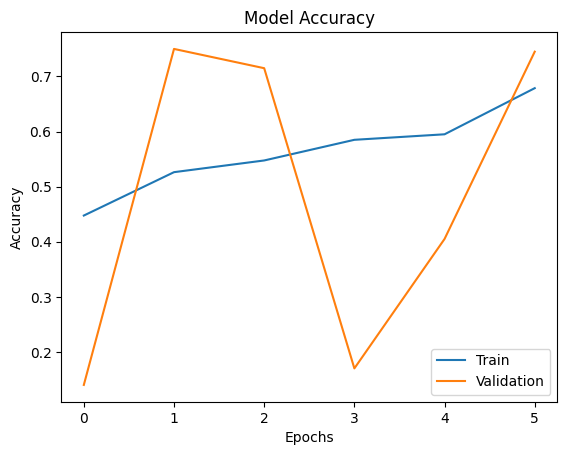

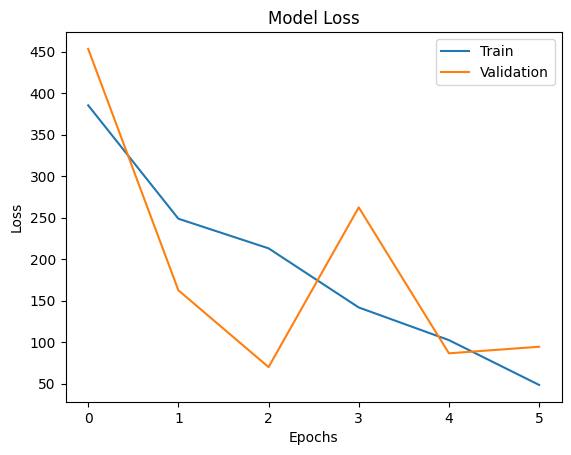

7/7 [==============================] - 3s 229ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Class: P1
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Class: P2
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Class: P3
Precision: 0.7540
Recall: 0.9400
F1-score: 0.8368
Class: P4
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
Class: P5
Precision: 0.2222
Recall: 0.0714
F1-score: 0.1081


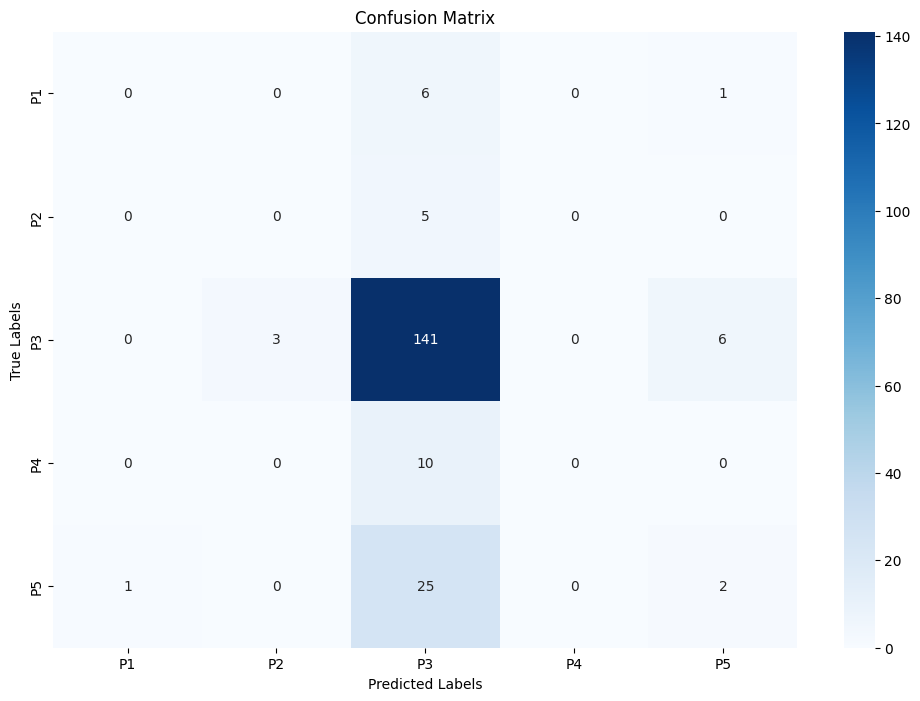

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 3000)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 3000, 100)    976000      ['input_4[0][0]']                
                                                                                                  
 bidirectional_6 (Bidirectional  (None, 3000, 128)   63744       ['embedding_3[0][0]']            
 )                                                                                                
                                                                                                  
 attention_6 (Attention)        (None, 3000, 128)    0           ['bidirectional_6[0][0]',  

In [ ]:
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import ADASYN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.layers import Attention, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
import seaborn as sns  # Add this import

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Load CSV dataset
data = pd.read_csv('/content/drive/MyDrive/Datasets/Eclipse_dataset_new1_small.csv')

# Count the number of samples for each class
class_counts = data['Priority'].value_counts()

# Find the class with the minimum number of samples
minority_class = class_counts.idxmin()

print("Minority class:", minority_class)
print(class_counts)


# Text preprocessing steps
def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase conversion
        text = text.lower()

        # Remove punctuation and special characters
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]
        text = ' '.join(tokens)

        # Stemming
        stemmer = PorterStemmer()
        tokens = text.split()
        tokens = [stemmer.stem(word) for word in tokens]
        text = ' '.join(tokens)

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        text = ' '.join(tokens)

    return text

# Apply text preprocessing to 'description' and 'title' columns
data['Description'] = data['Description'].apply(preprocess_text)
data['Title'] = data['Title'].apply(preprocess_text)

# Tokenize using Keras tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Description'] + ' ' + data['Title'])
max_sequence_length = 3000

# Convert text to sequences
X_sequences = tokenizer.texts_to_sequences(data['Description'] + ' ' + data['Title'])

# Pad sequences
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Separate input data and labels
X_input = X_padded
y_input = data['Priority']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, test_size=0.2, random_state=42)

from sklearn.preprocessing import LabelEncoder

# Encode string labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to categorical
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train_encoded, num_classes)
y_test = to_categorical(y_test_encoded, num_classes)

# Load pre-trained GloVe embeddings
glove_path = '/content/drive/MyDrive/Datasets/glove.6B.100d.txt'  # Specify the path to your GloVe embeddings file
embedding_dim = 100  # Change this according to the GloVe embeddings you're using

def create_glove_embedding_matrix(word_index, embedding_dim, glove_path):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    with open(glove_path, encoding='utf-8') as f:
        for line in f:
            word, embedding = line.split(maxsplit=1)
            if word in word_index:
                embedding_matrix[word_index[word]] = np.fromstring(embedding, sep=' ')
    return embedding_matrix

glove_embedding_matrix = create_glove_embedding_matrix(tokenizer.word_index, embedding_dim, glove_path)

# Build HAN model with GloVe embeddings
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[glove_embedding_matrix], trainable=False)(input_layer)
word_encoder = Bidirectional(GRU(64, return_sequences=True))(embedding_layer)
word_attention = Attention()([word_encoder, word_encoder])
word_flatten = Flatten()(word_attention)
word_dense = Dense(64)(word_flatten)
word_repeat = RepeatVector(max_sequence_length)(word_dense)
sentence_encoder = Bidirectional(GRU(64, return_sequences=True))(word_repeat)
sentence_attention = Attention()([sentence_encoder, sentence_encoder])
sentence_flatten = Flatten()(sentence_attention)
sentence_dense = Dense(64)(sentence_flatten)
output_layer = Dense(num_classes, activation='softmax')(sentence_dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10, callbacks=[early_stopping])


# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Calculate precision, recall, and F1-score for each class
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_original = label_encoder.inverse_transform(y_test_encoded)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

precision = precision_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_)
recall = recall_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_)
f1 = f1_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_)

# Display precision, recall, and F1-score for each class
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1[i]:.4f}")
    print("="*30)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=label_encoder.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print model summary
model.summary()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Glove, No eqaulised, ADASYN

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Minority class: P2
P3    712
P5    152
P4     64
P1     39
P2     33
Name: Priority, dtype: int64
Epoch 1/10
90/90 [==============================] - 73s 713ms/step - loss: 123.1050 - accuracy: 0.2333 - val_loss: 14.5838 - val_accuracy: 0.2286
Epoch 2/10
90/90 [==============================] - 63s 702ms/step - loss: 9.5359 - accuracy: 0.2985 - val_loss: 11.0862 - val_accuracy: 0.2833
Epoch 3/10
90/90 [==============================] - 66s 732ms/step - loss: 8.5368 - accuracy: 0.3290 - val_loss: 19.7103 - val_accuracy: 0.2525
Epoch 4/10
90/90 [==============================] - 62s 692ms/step - loss: 10.9694 - accuracy: 0.3729 - val_loss: 20.7553 - val_accuracy: 0.2412
Epoch 5/10
90/90 [==============================] - 66s 738ms/step - loss: 14.8334 - accuracy: 0.4297 - val_loss: 24.0551 - val_accuracy: 0.3156


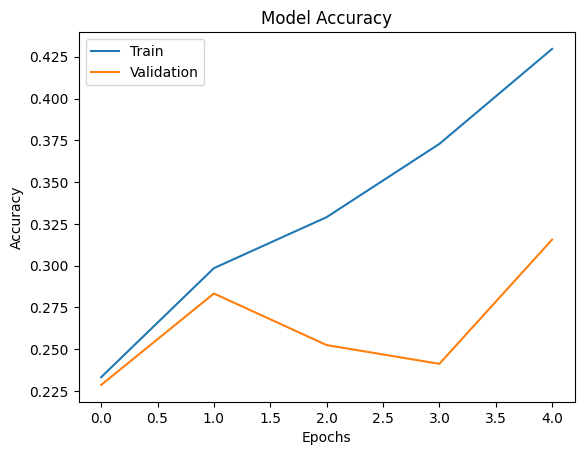

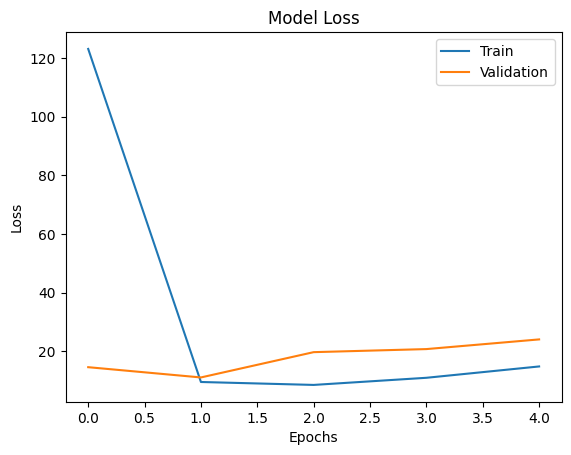

23/23 [==============================] - 7s 236ms/step
Class: P1
Precision: 0.5294
Recall: 0.1901
F1-score: 0.2798
Class: P2
Precision: 0.2000
Recall: 0.0159
F1-score: 0.0294
Class: P3
Precision: 0.2865
Recall: 0.6125
F1-score: 0.3904
Class: P4
Precision: 0.2500
Recall: 0.2761
F1-score: 0.2624
Class: P5
Precision: 0.2346
Recall: 0.2517
F1-score: 0.2428


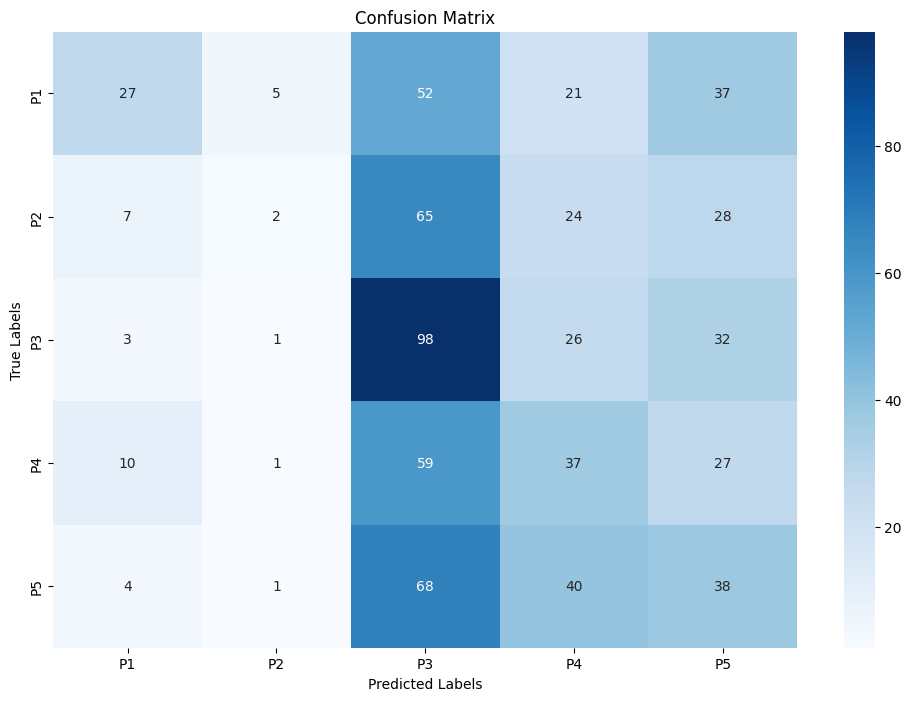

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 3000)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 3000, 100)    976000      ['input_3[0][0]']                
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 3000, 128)   63744       ['embedding_2[0][0]']            
 )                                                                                                
                                                                                                  
 attention_4 (Attention)        (None, 3000, 128)    0           ['bidirectional_4[0][0]',  

In [ ]:
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import ADASYN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.layers import Attention, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
import seaborn as sns  # Add this import

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Load CSV dataset
data = pd.read_csv('/content/drive/MyDrive/Datasets/Eclipse_dataset_new1_small.csv')

# Count the number of samples for each class
class_counts = data['Priority'].value_counts()

# Find the class with the minimum number of samples
minority_class = class_counts.idxmin()

print("Minority class:", minority_class)
print(class_counts)


# Text preprocessing steps
def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase conversion
        text = text.lower()

        # Remove punctuation and special characters
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]
        text = ' '.join(tokens)

        # Stemming
        stemmer = PorterStemmer()
        tokens = text.split()
        tokens = [stemmer.stem(word) for word in tokens]
        text = ' '.join(tokens)

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        text = ' '.join(tokens)

    return text

# Apply text preprocessing to 'description' and 'title' columns
data['Description'] = data['Description'].apply(preprocess_text)
data['Title'] = data['Title'].apply(preprocess_text)

# Tokenize using Keras tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Description'] + ' ' + data['Title'])
max_sequence_length = 3000

# Convert text to sequences
X_sequences = tokenizer.texts_to_sequences(data['Description'] + ' ' + data['Title'])

# Pad sequences
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Separate input data and labels
X_input = X_padded
y_input = data['Priority']

# Apply ADASYN oversampling
adasyn = ADASYN()
X_resampled, y_resampled = adasyn.fit_resample(X_input, y_input)

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

from sklearn.preprocessing import LabelEncoder

# Encode string labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to categorical
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train_encoded, num_classes)
y_test = to_categorical(y_test_encoded, num_classes)

# Load pre-trained GloVe embeddings
glove_path = '/content/drive/MyDrive/Datasets/glove.6B.100d.txt'  # Specify the path to your GloVe embeddings file
embedding_dim = 100  # Change this according to the GloVe embeddings you're using

def create_glove_embedding_matrix(word_index, embedding_dim, glove_path):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    with open(glove_path, encoding='utf-8') as f:
        for line in f:
            word, embedding = line.split(maxsplit=1)
            if word in word_index:
                embedding_matrix[word_index[word]] = np.fromstring(embedding, sep=' ')
    return embedding_matrix

glove_embedding_matrix = create_glove_embedding_matrix(tokenizer.word_index, embedding_dim, glove_path)

# Build HAN model with GloVe embeddings
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[glove_embedding_matrix], trainable=False)(input_layer)
word_encoder = Bidirectional(GRU(64, return_sequences=True))(embedding_layer)
word_attention = Attention()([word_encoder, word_encoder])
word_flatten = Flatten()(word_attention)
word_dense = Dense(64)(word_flatten)
word_repeat = RepeatVector(max_sequence_length)(word_dense)
sentence_encoder = Bidirectional(GRU(64, return_sequences=True))(word_repeat)
sentence_attention = Attention()([sentence_encoder, sentence_encoder])
sentence_flatten = Flatten()(sentence_attention)
sentence_dense = Dense(64)(sentence_flatten)
output_layer = Dense(num_classes, activation='softmax')(sentence_dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10, callbacks=[early_stopping])


# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Calculate precision, recall, and F1-score for each class
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_original = label_encoder.inverse_transform(y_test_encoded)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

precision = precision_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_)
recall = recall_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_)
f1 = f1_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_)

# Display precision, recall, and F1-score for each class
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1[i]:.4f}")
    print("="*30)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=label_encoder.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print model summary
model.summary()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


# GLove , eqaulised , NO ADASYN

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Minority class: P1
P4    263
P3    256
P2    252
P5    252
P1    251
Name: Priority, dtype: int64
Epoch 1/10
32/32 [==============================] - 44s 942ms/step - loss: 341.2690 - accuracy: 0.1914 - val_loss: 172.6661 - val_accuracy: 0.2706
Epoch 2/10
32/32 [==============================] - 24s 748ms/step - loss: 65.4972 - accuracy: 0.2787 - val_loss: 40.4142 - val_accuracy: 0.2824
Epoch 3/10
32/32 [==============================] - 22s 701ms/step - loss: 17.5282 - accuracy: 0.3965 - val_loss: 19.1735 - val_accuracy: 0.2745
Epoch 4/10
32/32 [==============================] - 23s 715ms/step - loss: 6.1396 - accuracy: 0.5201 - val_loss: 13.1758 - val_accuracy: 0.2863
Epoch 5/10
32/32 [==============================] - 23s 709ms/step - loss: 3.1557 - accuracy: 0.6261 - val_loss: 11.0464 - val_accuracy: 0.2902
Epoch 6/10
32/32 [==============================

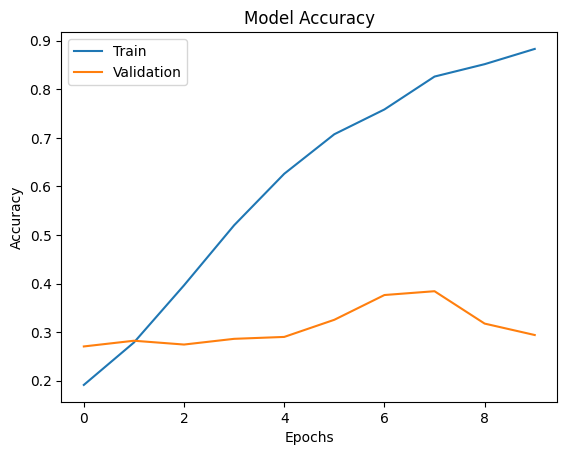

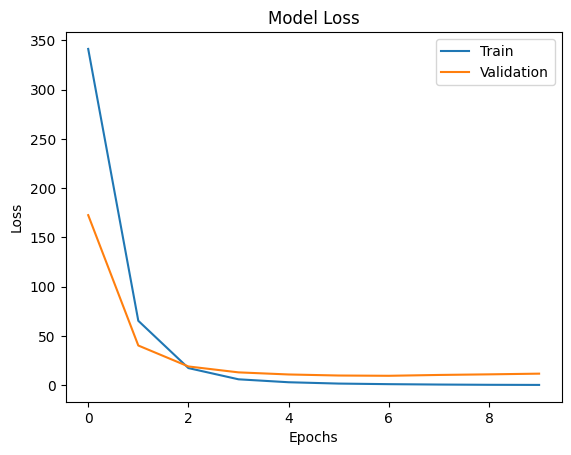

8/8 [==============================] - 3s 233ms/step
Class: P1
Precision: 0.5484
Recall: 0.3269
F1-score: 0.4096
Class: P2
Precision: 0.2857
Recall: 0.3333
F1-score: 0.3077
Class: P3
Precision: 0.3871
Recall: 0.2308
F1-score: 0.2892
Class: P4
Precision: 0.3714
Recall: 0.5306
F1-score: 0.4370
Class: P5
Precision: 0.3833
Recall: 0.4792
F1-score: 0.4259


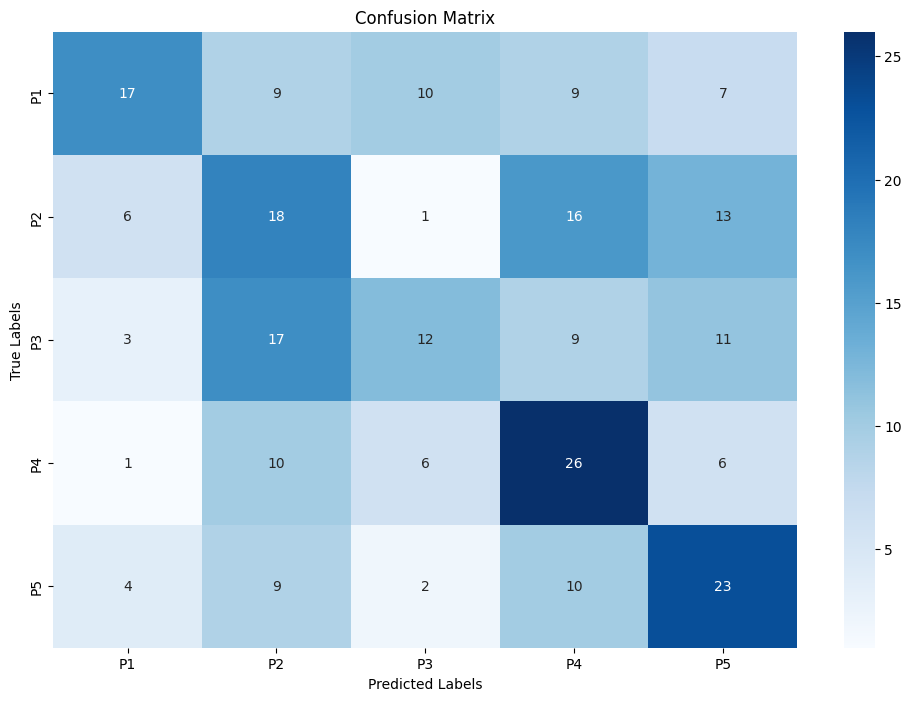

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 3000)]       0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 3000, 100)    1198200     ['input_5[0][0]']                
                                                                                                  
 bidirectional_8 (Bidirectional  (None, 3000, 128)   63744       ['embedding_4[0][0]']            
 )                                                                                                
                                                                                                  
 attention_8 (Attention)        (None, 3000, 128)    0           ['bidirectional_8[0][0]',  

In [ ]:
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import ADASYN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.layers import Attention, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
import seaborn as sns  # Add this import

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Load CSV dataset
data = pd.read_csv('/content/drive/MyDrive/Datasets/Equalised_eclipse_jdt_250each.csv')

# Count the number of samples for each class
class_counts = data['Priority'].value_counts()

# Find the class with the minimum number of samples
minority_class = class_counts.idxmin()

print("Minority class:", minority_class)
print(class_counts)


# Text preprocessing steps
def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase conversion
        text = text.lower()

        # Remove punctuation and special characters
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]
        text = ' '.join(tokens)

        # Stemming
        stemmer = PorterStemmer()
        tokens = text.split()
        tokens = [stemmer.stem(word) for word in tokens]
        text = ' '.join(tokens)

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        text = ' '.join(tokens)

    return text

# Apply text preprocessing to 'description' and 'title' columns
data['Description'] = data['Description'].apply(preprocess_text)
data['Title'] = data['Title'].apply(preprocess_text)

# Tokenize using Keras tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Description'] + ' ' + data['Title'])
max_sequence_length = 3000

# Convert text to sequences
X_sequences = tokenizer.texts_to_sequences(data['Description'] + ' ' + data['Title'])

# Pad sequences
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Separate input data and labels
X_input = X_padded
y_input = data['Priority']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, test_size=0.2, random_state=42)

from sklearn.preprocessing import LabelEncoder

# Encode string labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to categorical
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train_encoded, num_classes)
y_test = to_categorical(y_test_encoded, num_classes)

# Load pre-trained GloVe embeddings
glove_path = '/content/drive/MyDrive/Datasets/glove.6B.100d.txt'  # Specify the path to your GloVe embeddings file
embedding_dim = 100  # Change this according to the GloVe embeddings you're using

def create_glove_embedding_matrix(word_index, embedding_dim, glove_path):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    with open(glove_path, encoding='utf-8') as f:
        for line in f:
            word, embedding = line.split(maxsplit=1)
            if word in word_index:
                embedding_matrix[word_index[word]] = np.fromstring(embedding, sep=' ')
    return embedding_matrix

glove_embedding_matrix = create_glove_embedding_matrix(tokenizer.word_index, embedding_dim, glove_path)

# Build HAN model with GloVe embeddings
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[glove_embedding_matrix], trainable=False)(input_layer)
word_encoder = Bidirectional(GRU(64, return_sequences=True))(embedding_layer)
word_attention = Attention()([word_encoder, word_encoder])
word_flatten = Flatten()(word_attention)
word_dense = Dense(64)(word_flatten)
word_repeat = RepeatVector(max_sequence_length)(word_dense)
sentence_encoder = Bidirectional(GRU(64, return_sequences=True))(word_repeat)
sentence_attention = Attention()([sentence_encoder, sentence_encoder])
sentence_flatten = Flatten()(sentence_attention)
sentence_dense = Dense(64)(sentence_flatten)
output_layer = Dense(num_classes, activation='softmax')(sentence_dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10, callbacks=[early_stopping])


# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Calculate precision, recall, and F1-score for each class
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_original = label_encoder.inverse_transform(y_test_encoded)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

precision = precision_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_)
recall = recall_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_)
f1 = f1_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_)

# Display precision, recall, and F1-score for each class
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1[i]:.4f}")
    print("="*30)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=label_encoder.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print model summary
model.summary()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Glove, unequalised, full datset, no adasyn

In [ ]:
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import ADASYN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.layers import Attention, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
import seaborn as sns  # Add this import

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Load CSV dataset
data = pd.read_csv('/content/drive/MyDrive/Datasets/Eclipse_dataset_new1.csv')

# Count the number of samples for each class
class_counts = data['Priority'].value_counts()

# Find the class with the minimum number of samples
minority_class = class_counts.idxmin()

print("Minority class:", minority_class)
print(class_counts)


# Text preprocessing steps
def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase conversion
        text = text.lower()

        # Remove punctuation and special characters
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]
        text = ' '.join(tokens)

        # Stemming
        stemmer = PorterStemmer()
        tokens = text.split()
        tokens = [stemmer.stem(word) for word in tokens]
        text = ' '.join(tokens)

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        text = ' '.join(tokens)

    return text

# Apply text preprocessing to 'description' and 'title' columns
data['Description'] = data['Description'].apply(preprocess_text)
data['Title'] = data['Title'].apply(preprocess_text)

# Tokenize using Keras tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Description'] + ' ' + data['Title'])
max_sequence_length = 3000

# Convert text to sequences
X_sequences = tokenizer.texts_to_sequences(data['Description'] + ' ' + data['Title'])

# Pad sequences
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Separate input data and labels
X_input = X_padded
y_input = data['Priority']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, test_size=0.2, random_state=42)

from sklearn.preprocessing import LabelEncoder

# Encode string labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to categorical
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train_encoded, num_classes)
y_test = to_categorical(y_test_encoded, num_classes)

# Load pre-trained GloVe embeddings
glove_path = '/content/drive/MyDrive/Datasets/glove.6B.100d.txt'  # Specify the path to your GloVe embeddings file
embedding_dim = 100  # Change this according to the GloVe embeddings you're using

def create_glove_embedding_matrix(word_index, embedding_dim, glove_path):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    with open(glove_path, encoding='utf-8') as f:
        for line in f:
            word, embedding = line.split(maxsplit=1)
            if word in word_index:
                embedding_matrix[word_index[word]] = np.fromstring(embedding, sep=' ')
    return embedding_matrix

glove_embedding_matrix = create_glove_embedding_matrix(tokenizer.word_index, embedding_dim, glove_path)

# Build HAN model with GloVe embeddings
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[glove_embedding_matrix], trainable=False)(input_layer)
word_encoder = Bidirectional(GRU(64, return_sequences=True))(embedding_layer)
word_attention = Attention()([word_encoder, word_encoder])
word_flatten = Flatten()(word_attention)
word_dense = Dense(64)(word_flatten)
word_repeat = RepeatVector(max_sequence_length)(word_dense)
sentence_encoder = Bidirectional(GRU(64, return_sequences=True))(word_repeat)
sentence_attention = Attention()([sentence_encoder, sentence_encoder])
sentence_flatten = Flatten()(sentence_attention)
sentence_dense = Dense(64)(sentence_flatten)
output_layer = Dense(num_classes, activation='softmax')(sentence_dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10, callbacks=[early_stopping])


# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Calculate precision, recall, and F1-score for each class
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_original = label_encoder.inverse_transform(y_test_encoded)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

precision = precision_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_)
recall = recall_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_)
f1 = f1_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_)

# Display precision, recall, and F1-score for each class
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1[i]:.4f}")
    print("="*30)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=label_encoder.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print model summary
model.summary()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/drive
Minority class: P5
P3    74830
P2     5108
P1     2077
P4     1942
P5     1199
Name: Priority, dtype: int64


AttributeError: ignored

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/drive
Minority class: P1
P4    263
P3    256
P2    252
P5    252
P1    251
Name: Priority, dtype: int64
Epoch 1/10
32/32 [==============================] - 41s 845ms/step - loss: 307.9106 - accuracy: 0.1992 - val_loss: 103.9309 - val_accuracy: 0.1843
Epoch 2/10
32/32 [==============================] - 33s 1s/step - loss: 58.9719 - accuracy: 0.3013 - val_loss: 25.8541 - val_accuracy: 0.2667
Epoch 3/10
32/32 [==============================] - 23s 713ms/step - loss: 13.9709 - accuracy: 0.3209 - val_loss: 13.4800 - val_accuracy: 0.2471
Epoch 4/10
32/32 [==============================] - 23s 723ms/step - loss: 6.4511 - accuracy: 0.4583 - val_loss: 10.4233 - val_accuracy: 0.2667
Epoch 5/10
32/32 [==============================] - 26s 802ms/step - loss: 4.1051 - accuracy: 0.5211 - val_loss: 7.3248 - val_accuracy: 0.3333
Epoch 6/10
32/32 [==============================] - 23s 715ms/step - loss: 2.7280 - accuracy: 0.5653 - val_loss: 6.6643 - val_accuracy: 0.2941
Epoch 7/10
3

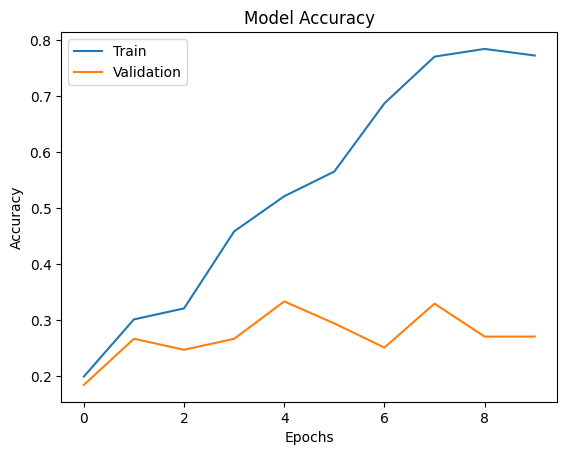

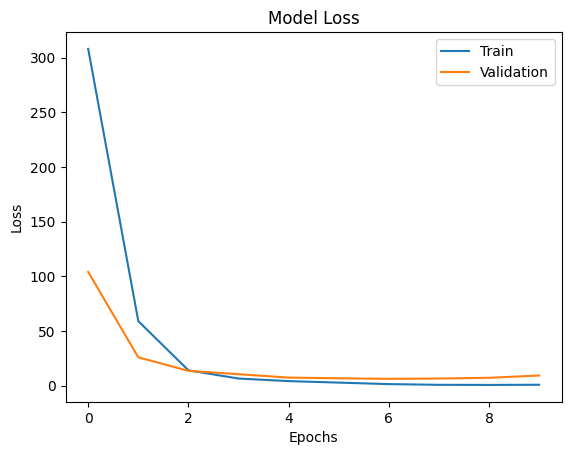

8/8 [==============================] - 3s 242ms/step
Class: P1
Precision: 0.4615
Recall: 0.1154
F1-score: 0.1846
Class: P2
Precision: 0.2386
Recall: 0.3889
F1-score: 0.2958
Class: P3
Precision: 0.2537
Recall: 0.3269
F1-score: 0.2857
Class: P4
Precision: 0.3333
Recall: 0.1633
F1-score: 0.2192
Class: P5
Precision: 0.1905
Recall: 0.2500
F1-score: 0.2162


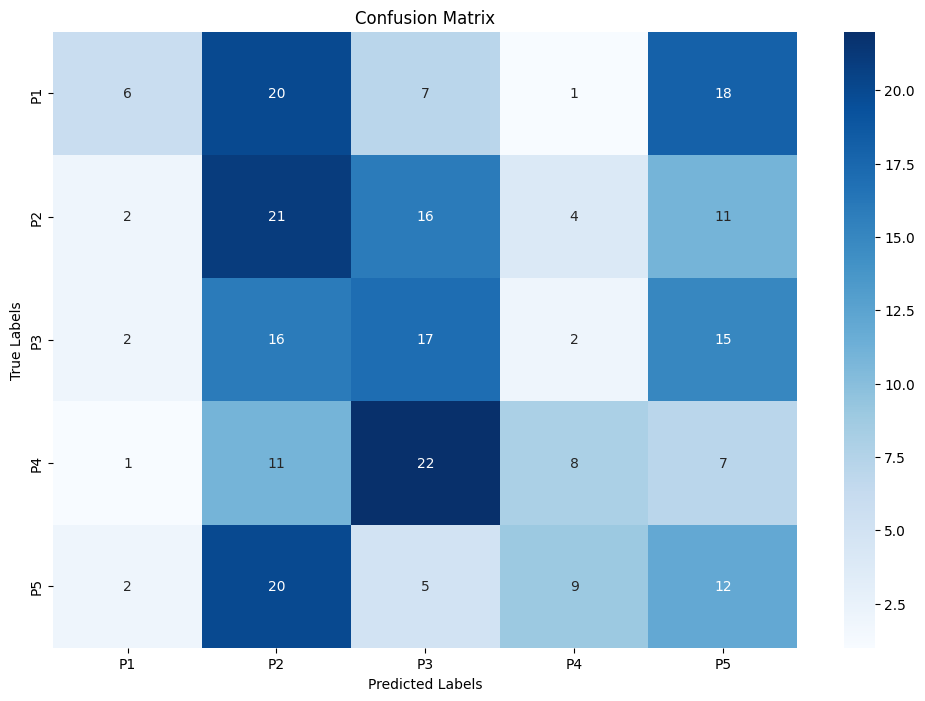

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3000)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 3000, 100)            1198200   ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 3000, 128)            63744     ['embedding[0][0]']           
 al)                                                                                              
                                                                                                  
 attention (Attention)       (None, 3000, 128)            0         ['bidirectional[0][0]',   

In [ ]:
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import ADASYN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, TimeDistributed, Bidirectional
from tensorflow.keras.layers import Attention, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import RepeatVector
import seaborn as sns  # Add this import

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Load CSV dataset
data = pd.read_csv('/content/drive/MyDrive/Datasets/Equalised_eclipse_jdt_250each.csv')

# Count the number of samples for each class
class_counts = data['Priority'].value_counts()

# Find the class with the minimum number of samples
minority_class = class_counts.idxmin()

print("Minority class:", minority_class)
print(class_counts)


# Text preprocessing steps
def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase conversion
        text = text.lower()

        # Remove punctuation and special characters
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]
        text = ' '.join(tokens)

        # Stemming
        stemmer = PorterStemmer()
        tokens = text.split()
        tokens = [stemmer.stem(word) for word in tokens]
        text = ' '.join(tokens)

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        text = ' '.join(tokens)

    return text

# Apply text preprocessing to 'description' and 'title' columns
data['Description'] = data['Description'].apply(preprocess_text)
data['Title'] = data['Title'].apply(preprocess_text)

# Tokenize using Keras tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['Description'] + ' ' + data['Title'])
max_sequence_length = 3000

# Convert text to sequences
X_sequences = tokenizer.texts_to_sequences(data['Description'] + ' ' + data['Title'])

# Pad sequences
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Separate input data and labels
X_input = X_padded
y_input = data['Priority']

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X_input, y_input, test_size=0.2, random_state=42)

from sklearn.preprocessing import LabelEncoder

# Encode string labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to categorical
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train_encoded, num_classes)
y_test = to_categorical(y_test_encoded, num_classes)

# Load pre-trained GloVe embeddings
glove_path = '/content/drive/MyDrive/Datasets/glove.6B.100d.txt'  # Specify the path to your GloVe embeddings file
embedding_dim = 100  # Change this according to the GloVe embeddings you're using

def create_glove_embedding_matrix(word_index, embedding_dim, glove_path):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    with open(glove_path, encoding='utf-8') as f:
        for line in f:
            word, embedding = line.split(maxsplit=1)
            if word in word_index:
                embedding_matrix[word_index[word]] = np.fromstring(embedding, sep=' ')
    return embedding_matrix

glove_embedding_matrix = create_glove_embedding_matrix(tokenizer.word_index, embedding_dim, glove_path)

# Build HAN model with GloVe embeddings
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[glove_embedding_matrix], trainable=False)(input_layer)
word_encoder = Bidirectional(GRU(64, return_sequences=True))(embedding_layer)
word_attention = Attention()([word_encoder, word_encoder])
word_flatten = Flatten()(word_attention)
word_dense = Dense(64)(word_flatten)
word_repeat = RepeatVector(max_sequence_length)(word_dense)
sentence_encoder = Bidirectional(GRU(64, return_sequences=True))(word_repeat)
sentence_attention = Attention()([sentence_encoder, sentence_encoder])
sentence_flatten = Flatten()(sentence_attention)
sentence_dense = Dense(64)(sentence_flatten)
output_layer = Dense(num_classes, activation='softmax')(sentence_dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10, callbacks=[early_stopping])


# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Calculate precision, recall, and F1-score for each class
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_original = label_encoder.inverse_transform(y_test_encoded)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

precision = precision_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_)
recall = recall_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_)
f1 = f1_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_)

# Display precision, recall, and F1-score for each class
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1[i]:.4f}")
    print("="*30)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=label_encoder.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print model summary
model.summary()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

In [ ]:
import pandas as pd
import re
import string
import numpy as np
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Bidirectional, Attention, Flatten, RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Add

nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Mount Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

# Load CSV dataset
data = pd.read_csv('/content/drive/MyDrive/Datasets/Equalised_eclipse_jdt_250each.csv')

# Count the number of samples for each class
class_counts = data['Priority'].value_counts()

# Find the class with the minimum number of samples
minority_class = class_counts.idxmin()

print("Minority class:", minority_class)
print(class_counts)

# Text preprocessing steps
def preprocess_text(text):
    if isinstance(text, str):
        # Lowercase conversion
        text = text.lower()

        # Remove punctuation and special characters
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = text.split()
        tokens = [word for word in tokens if word not in stop_words]
        text = ' '.join(tokens)

        # Stemming
        stemmer = PorterStemmer()
        tokens = text.split()
        tokens = [stemmer.stem(word) for word in tokens]
        text = ' '.join(tokens)

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = text.split()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        text = ' '.join(tokens)

    return text

# Apply text preprocessing to 'description' and 'title' columns
data['Description'] = data['Description'].apply(preprocess_text)
data['Title'] = data['Title'].apply(preprocess_text)

# Tokenize using DistilBERT tokenizer
# (Please make sure you have the appropriate libraries installed for DistilBERT tokenization)
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_sequence_length = 3000

def tokenize_text(text):
    if isinstance(text, (str, int, float)):
        text = str(text)  # Convert text to string if it's not already

        tokens = tokenizer.encode_plus(text, add_special_tokens=True, max_length=max_sequence_length, padding='max_length', truncation=True)
        input_ids = tokens['input_ids']
        attention_mask = tokens['attention_mask']
    else:
        input_ids = []
        attention_mask = []
    return input_ids, attention_mask

# Apply tokenization to 'Description' and 'Title' columns
data['Description'] = data['Description'].apply(tokenize_text)
data['Title'] = data['Title'].apply(tokenize_text)

# Convert tokenized data to numpy arrays
input_ids = np.array([item[0] for item in data['Description']])
attention_masks = np.array([item[1] for item in data['Description']])

# Reshape input IDs and attention masks to have at most 2 dimensions
input_ids = input_ids.reshape(input_ids.shape[0], -1)
attention_masks = attention_masks.reshape(attention_masks.shape[0], -1)

# Combine input IDs and attention masks
X_input = np.concatenate((input_ids, attention_masks), axis=1)
y_input = data['Priority']

# Apply ADASYN oversampling
adasyn = ADASYN()
X_resampled, y_resampled = adasyn.fit_resample(X_input, y_input)

# Separate the resampled input IDs and attention masks
input_ids_resampled = X_resampled[:, :max_sequence_length]
attention_masks_resampled = X_resampled[:, max_sequence_length:]

# Perform train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_ids_resampled, y_resampled, test_size=0.2, random_state=42)

# Pad sequences
X_train = pad_sequences(X_train, maxlen=max_sequence_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_sequence_length, padding='post', truncating='post')

from sklearn.preprocessing import LabelEncoder

# Encode string labels to numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to categorical
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train_encoded, num_classes)
y_test = to_categorical(y_test_encoded, num_classes)

# Load pre-trained GloVe embeddings
glove_path = '/content/drive/MyDrive/Datasets/glove.6B.100d.txt'  # Specify the path to your GloVe embeddings file
embedding_dim = 100  # Change this according to the GloVe embeddings you're using

def create_glove_embedding_matrix(word_index, embedding_dim, glove_path):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    with open(glove_path, encoding='utf-8') as f:
        for line in f:
            word, embedding = line.split(maxsplit=1)
            if word in word_index:
                embedding_matrix[word_index[word]] = np.fromstring(embedding, sep=' ')
    return embedding_matrix

glove_embedding_matrix = create_glove_embedding_matrix(tokenizer.get_vocab(), embedding_dim, glove_path)

# Build HAN model with GloVe embeddings
input_layer = Input(shape=(max_sequence_length,))
embedding_layer = Embedding(len(tokenizer.get_vocab()) + 1, embedding_dim, weights=[glove_embedding_matrix], trainable=False)(input_layer)
word_encoder = Bidirectional(GRU(64, return_sequences=True))(embedding_layer)
word_attention = Attention()([word_encoder, word_encoder])
word_flatten = Flatten()(word_attention)
word_dense = Dense(64)(word_flatten)
word_repeat = RepeatVector(max_sequence_length)(word_dense)
sentence_encoder = Bidirectional(GRU(64, return_sequences=True))(word_repeat)
sentence_attention = Attention()([sentence_encoder, sentence_encoder])
sentence_flatten = Flatten()(sentence_attention)
sentence_dense = Dense(64)(sentence_flatten)
output_layer = Dense(num_classes, activation='softmax')(sentence_dense)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=10, callbacks=[early_stopping])

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

# Calculate precision, recall, and F1-score for each class
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_original = label_encoder.inverse_transform(y_test_encoded)
y_pred_original = label_encoder.inverse_transform(y_pred_classes)

precision = precision_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_)
recall = recall_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_)
f1 = f1_score(y_test_original, y_pred_original, average=None, labels=label_encoder.classes_)

# Display precision, recall, and F1-score for each class
for i, class_name in enumerate(label_encoder.classes_):
    print(f"Class: {class_name}")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1[i]:.4f}")
    print("="*30)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=label_encoder.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print model summary
model.summary()

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Minority class: P1
P4    263
P3    256
P2    252
P5    252
P1    251
Name: Priority, dtype: int64


ValueError: ignored